In [1]:
import pandas as pd
import os
import time
import datetime        #new added
import numpy as np
from datetime import datetime, timedelta 

from docx.enum.text import WD_ALIGN_PARAGRAPH
import pyodbc
from YB_load import yb_load
from YB_load import yb_load_file

import openpyxl
from datetime import date
import math

from docx import Document
from docx.shared import Inches
from docx.shared import Pt
from docx.enum.table import WD_TABLE_ALIGNMENT
from docx.shared import RGBColor
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml


import collections
from collections import deque

from weekly_sales_functions_Nov16 import *

ntwk = 66
lgl_entity = 38
# ob_buyers_sorted = pd.DataFrame

user='emmaz'
pw='amme@xpS063A'



In [2]:
# conn = connectYellowBrick('py1uspa1',user,pw)
# curs = conn.cursor()
conn = connectYB(database_name='py1uspa1',uid='emmaz',pwd='amme@xpS063A')
curs = conn.cursor()

YellowBrick using Linux jdbc connection: py1uspa1


- STOP DATE: the most recent Saturday

In [3]:
latest_sat = '0227'

In [4]:
stop_date='2021'+latest_sat
stop_date = datetime.strptime(stop_date, "%Y%m%d")

filename_BB='SalesReportAllBanners_bowlbasket_WE' + latest_sat + '21.docx'
filename_PB='SalesReportAllBanners_paperbird_WE'+ latest_sat + '21.docx'

# filename_BB='SalesReportAllBanners_Flour_WE' + latest_sat + '21.docx'

- YAGO DATE: YAGO of the most recent Saturday
- 26 WKs PRIOR YAGO DATE: these two dates are used for calculating average product share YAGO

In [5]:
stop_dt_yago = stop_date - timedelta(days=364)
print("stop_date:",stop_date)
print("stop_dt_yago:",stop_dt_yago)

stop_date: 2021-02-27 00:00:00
stop_dt_yago: 2020-02-29 00:00:00


- Read and Organize UPC file

In [6]:

xls = pd.ExcelFile('/sasuser/ASRetail/emmaz/OB/OwnBrand_UPClist_format_20201221.xlsx')
# OB/OwnBrand_UPClist_format_20201105.xlsx
upcs = pd.read_excel(xls, 'UPC',dtype={'UPC': object,'Hierarchy Level 2 Code':object})

records = str(upcs.shape[0])
print('data processing complete... '+records+' loaded')

#for identification i in graphing part
obupcs = upcs[["Division", "Series", "UPC",'Group Number', 'brand', 'productname', 'Hierarchy Level 3 Code','Hierarchy Level 2 Code', "Date", 'level_flag']]
obupcs=obupcs.reset_index(drop=True)
obupcs.rename(columns={'Group Number':'grp_num', 'Hierarchy Level 3 Code':'hier_l3_cd','Hierarchy Level 2 Code':'hier_l2_cd', 'Date':'Conv_Date'}, inplace=True)

# convert to numbers
col = obupcs.columns.drop(["Division", 'Series', 'productname','Conv_Date','brand'])
obupcs[col] = obupcs[col].apply(pd.to_numeric, errors='coerce').reset_index(drop = True)


data processing complete... 1203 loaded


If we only want to see few or single categories..

In [7]:
# group num > 25 are currently groups not in final-update file
obupcs = obupcs.drop_duplicates().loc[obupcs.grp_num > 28]
# obupcs = obupcs.drop_duplicates().loc[obupcs.grp_num > 36]
# obupcs = obupcs.loc[~obupcs.grp_num.isin([1,2,3,4])]
# obupcs_fu = obupcs.loc[~obupcs.grp_num.isin([1,2,3,4,5,6,7,8,9,13])]
# obupcs = obupcs.loc[obupcs.productname.str.contains('Flour')]

In [8]:
obupcs[['grp_num','productname']].drop_duplicates()

,grp_num,productname
932,29,PB/Spreads/Butters
946,30,Refrigerated Milk Cream
994,31,Carbonated Soft Drinks
1032,32,Sparkling & Mineral Water
1056,33,Specialty Pasta Sauce
1084,34,Pasta Sauce
1096,35,Jellies/Jams/Spreads
1123,36,Cookies/Crackers
1160,37,Specialty Crackers
1188,38,Specialty Cookies


**YB UPLOADING UPCS**

In [9]:
yb_load(Df = obupcs, userid = user,passwd = pw, table_name = 'conv_upcs_ttl')
curs.execute("select count(*) from py1usta1.public.conv_upcs_ttl limit 1")
curs.fetchall()

Checking that the save and YBtools locations

Checking and removing if a table by the same name exists


Creating table


Here is your new table structure


***************************************************************

	 FIELD: 	 Pandas -> YB 

	 Division: 	 object -> VARCHAR( 18 )
	 Series: 	 object -> VARCHAR( 3 )
	 UPC: 	 int64 -> BIGINT
	 grpnum: 	 int64 -> BIGINT
	 brand: 	 object -> VARCHAR( 1 )
	 productname: 	 object -> VARCHAR( 25 )
	 hierl3cd: 	 float64 -> FLOAT
	 hierl2cd: 	 float64 -> FLOAT
	 ConvDate: 	 datetime64[ns] -> Date
	 levelflag: 	 int64 -> BIGINT
***************************************************************

Saving data frame to the drive for loading into YB

Bulk loading has commenced

removing pandas saved file


[(271,)]

**Create the full UPCs list in each category**
- All UPCs in each categories from Catalina WAKEFERN Hierachy + Unloaded New UPCs from WF teams

In [10]:
upc_cat_all = get_all_upcs_byCatgry(conn)

In [11]:
upc_cat_all

,upc,grpnum,levelflag,hier_cd
0,75764502160,38,3,54200.0
1,4410010316,30,3,30100.0
2,6150012642,31,3,50100.0
3,4119006959,33,3,28000.0
4,7800000269,31,3,50100.0
...,...,...,...,...
8149,5100013281,34,3,40200.0
8150,85290900330,30,3,30100.0
8151,4119046553,30,3,30100.0
8152,3663207344,30,3,30100.0


In [12]:
# check how many group of UPCs have been uploaded
upc_cat_all.sort_values('grpnum').grpnum.unique()

array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38])

In [13]:
# check how many UPCs in the total UPCs file
len(upc_cat_all)

8154

Check if there is multiple upc in SAME group 
there were multiple upc in DIFFERENT group, which makes sense, e.g. K-Cups belongs to Coffee, and MacCheese belongs to Soup

In [14]:
upc_count_by_group = upc_cat_all.groupby(['grpnum','upc']).upc.agg('count').to_frame('c')
upc_count_by_group.loc[upc_count_by_group.c>1]

,,c
grpnum,upc,


Broadcasting Convention Date to the whole OB (converted) Category list

In [15]:
# match the whole category file with its new ob brand conversion date
cols = list(upc_cat_all.columns.values)
cols.append('Conv_Date')

grp_date = obupcs[['grp_num','Conv_Date']].drop_duplicates()

upc_cat_all2 = upc_cat_all.merge(grp_date, left_on='grpnum', right_on='grp_num', how='left')[cols]

In [16]:
len(upc_cat_all2)

8154

In [17]:
len(upc_cat_all2.drop_duplicates())

8154

In [18]:
yb_load(Df = upc_cat_all2, userid = user,passwd = pw, table_name = 'upc_cat_all_ttl')

Checking that the save and YBtools locations

Checking and removing if a table by the same name exists


Creating table


Here is your new table structure


***************************************************************

	 FIELD: 	 Pandas -> YB 

	 upc: 	 int64 -> BIGINT
	 grpnum: 	 int64 -> BIGINT
	 levelflag: 	 int64 -> BIGINT
	 hiercd: 	 float64 -> FLOAT
	 ConvDate: 	 datetime64[ns] -> Date
***************************************************************

Saving data frame to the drive for loading into YB

Bulk loading has commenced

removing pandas saved file


True

In [19]:
curs.execute("select count(*) from py1usta1.public.upc_cat_all_ttl limit 1")
curs.fetchall()

[(8154,)]

# 2. Data Pulling from Server
#### Old Brand Share & New Brand Share's category shoppers all in same time period updated at 5/18/2020


    
#### For UPC level data, we can't use the same method for SR and PR & FG
    1. SR, we are identifying Old & New Products Sales by the conversion UPC list directly because we have the specific old brand & new brand UPCs
    
    2. PR & FG, we need to include more Old Brand Products beyond the conversion UPCs list because we do not have the specific old brand UPCs, like we do for SR

PriceRite and Fresh Grocer may sell some of those OB UPCs, but there are probably more that conversion UPCs list doesn't have. So the logic is: any OB items in the Category that are not 'New' will be regarded as 'Old' 


## 2.1 ShopRite

In [20]:
#fresh grocery site_id_txt
fg_store_nbr = (415,432,438,441,448,456,459,144,145,146,147)
fg_store = tuple([str(i) for i in fg_store_nbr])

In [21]:
shoprite_sales_cat,shoprite_sales_upc = get_trans_shoprite(ntwk, stop_dt_yago,stop_date,fg_store,conn)

## 2.2 PriceRite & Fresh Grocer

In [22]:
#some OB in conversion UPCs list are not standard format
ob_not_format = obupcs.loc[(obupcs.UPC < 4119000000) | (obupcs.UPC > 4119099999) ]
ob_not_format_upc = tuple(ob_not_format.UPC)

In [23]:
upc_level_all,cat_level_all = get_trans_pr_fg(ob_not_format_upc, ntwk, stop_dt_yago,stop_date,fg_store,conn)

# 3. Graphing

In [24]:
product_list = []
grp_num_list = []
division_list = []
#Sales:
avg_brand_share = []
avg_brand_share_newold = []
avg_brand_share_yago = []
#units:
avg_brand_share_u = []
avg_brand_share_newold_u = []
avg_brand_share_yago_u = []

In [25]:
# obupcs_fu = obupcs.loc[~obupcs.grp_num.isin(range(1,25))]
# obupcs_final = obupcs.loc[obupcs.grp_num <= 26]
# filename = 'SalesReportAllBanners_FinalUpdate_1031.docx'
# range_list = obupcs_final.sort_values(['brand','Division','grp_num'])['grp_num'].unique().tolist()
# brand_flag = 'b'

In [26]:
brand_flag = 'b'
filename = filename_BB
# filename = 'sg_cookies_crackers_1219.docx'
range_list = obupcs.loc[obupcs.brand == brand_flag].sort_values(['Division','grp_num'])['grp_num'].unique().tolist()

In [27]:
range_list

[30, 31, 34, 35, 36, 29, 32, 33, 37, 38]

In [28]:
# brand_flag = 'p'
# filename = filename_PB
# range_list = obupcs.loc[obupcs.brand == brand_flag].sort_values(['Division','grp_num'])['grp_num'].unique().tolist()

In [29]:
def line_graph(new_sales, old_sales, cat_sales, data_series, banner):
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(19,8))
    ax1.plot(date_series, cat_sales, color='grey',dashes=[6, 4])  
    ax1.set_ylabel('Category Sales', color='black')
    ax1.legend(['Category Sales'],bbox_to_anchor=(1.11,0.05), loc='center left')
    ax1.set_ylim(ymin=0)
#     ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])


    ax2 = ax1.twinx()
    ax2.plot(date_series, old_sales, color='royalblue')
    ax2.plot(date_series, new_sales, color='darkorange')        #marker='*', markersize=15, label='Blue stars'darkorange
    ax2.set_ylabel('Brand Sales', color='black')
    #ax2.set_ylim(ymin=0)
#     ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])
    # ax2.legend(['Old Brand Sales', brand_text+' Shoppers'])
    ax2.legend(['Old Brand Sales', brand_text+' Sales'],bbox_to_anchor=(1.11,0.20), loc='center left')

    
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax1.yaxis.set_major_formatter(tick) 
    ax2.yaxis.set_major_formatter(tick) 


    plt.rc('axes', titlesize=22) 
    plt.rc('axes', labelsize=22) 
    plt.rc('legend', fontsize=22)
    plt.rc('xtick', labelsize=22) 
    plt.rc('ytick', labelsize=22)  
    plt.xlabel('Date')
    plt.title('Sales Trend',fontsize=30)
    plt.show()
    #1015
#     fig_name = brand_text
    fig.savefig('pic1'+banner+'.png',bbox_inches='tight')

Convension Date 2020-07-12 00:00:00
Convension Date YAGO 2019-07-14 00:00:00
Convension Date 26 wks Pre 2020-01-12 00:00:00
Convension Date 26 wks Pre 2020-01-12 00:00:00


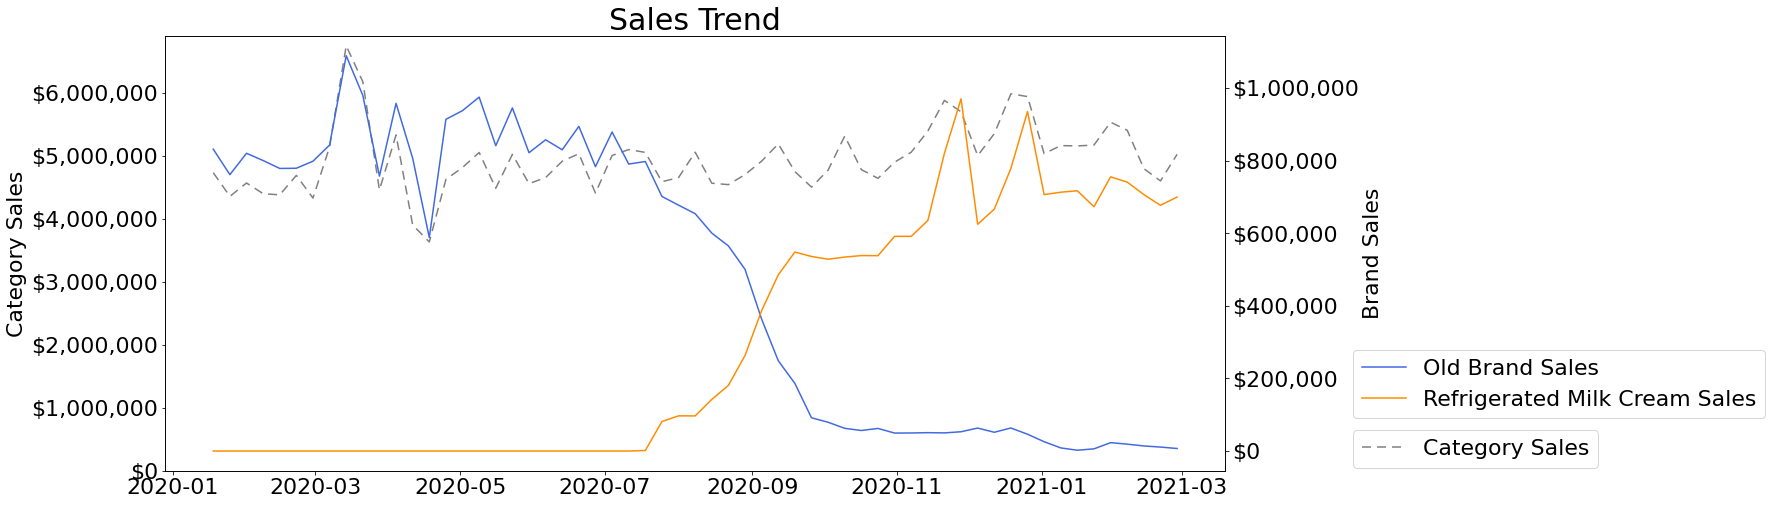

(848742.4757692309, 544432.9248484848, 4941424.876101694, 0.15722104982486834, 0.2048373851710499, 0.10753866753970807, 0.18301456065007354)
0.3850040813185374 ob_share_yago_PR
0.16723642889022358 ob_share_PR
-0.21776765242831383 share_diff_PR


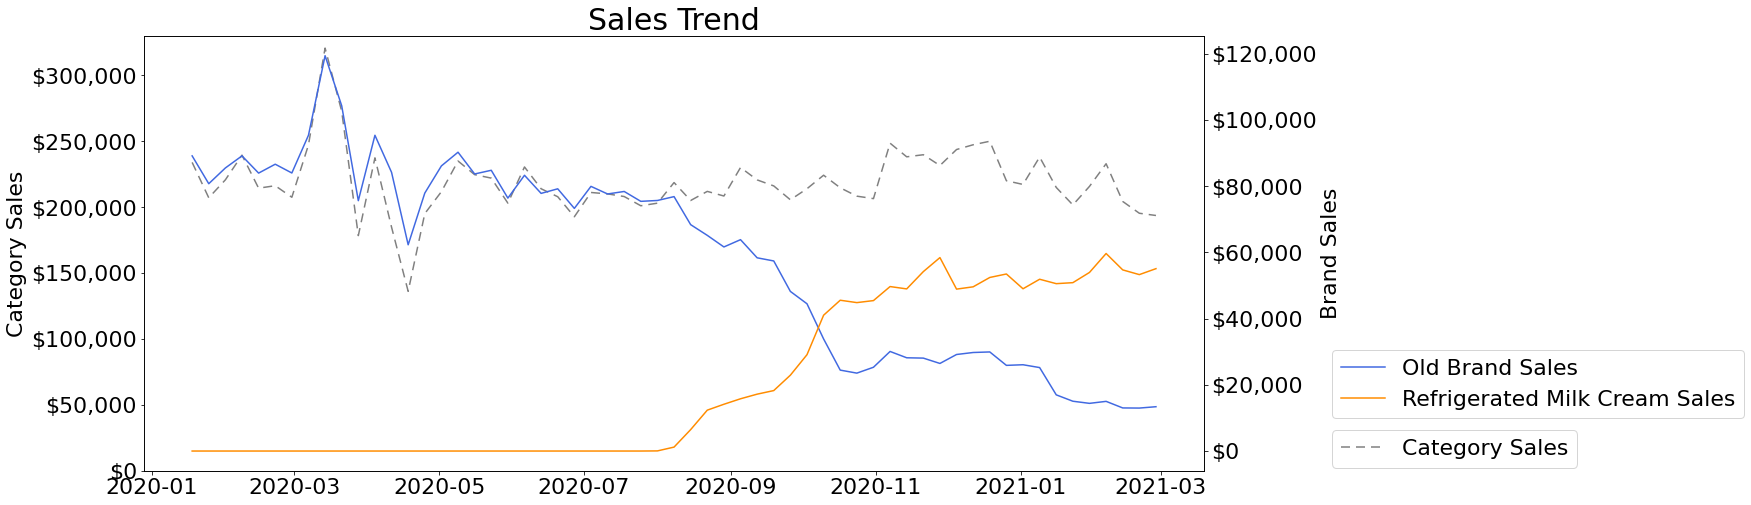

(84890.53153846154, 36653.003939393944, 218809.1559322033, 0.23716382579232698, 0.4772797270166087, 0.16723642889022358, 0.3850040813185374)


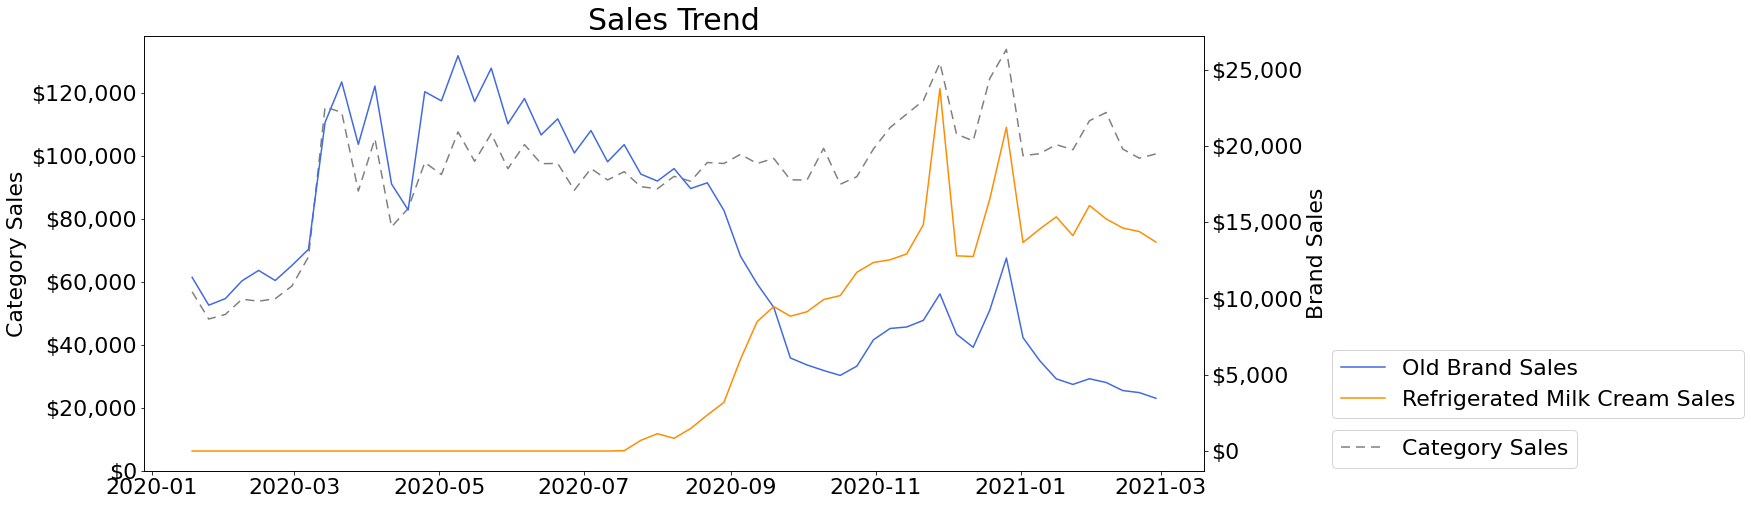

(18479.32615384615, 10751.977878787877, 95005.85593220338, 0.14169049140627626, 0.25426877722673114, 0.1043714006230663, 0.2219373952950133)
item_ttl (952112.3334615385, 591837.9066666666, 5255239.8879661, 0.16074364840570454, 0.22026703028854763, 0.10990783085388796, 0.19273863470570873)
----Refrigerated Milk Cream----
ob share SR new&old 0.1449035962976882
ob share new&old 0.1538633627679334
Convension Date 2020-07-19 00:00:00
Convension Date YAGO 2019-07-21 00:00:00
Convension Date 26 wks Pre 2020-01-19 00:00:00
Convension Date 26 wks Pre 2020-01-19 00:00:00


/apps_opensource/anaconda3/lib/python3.7/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


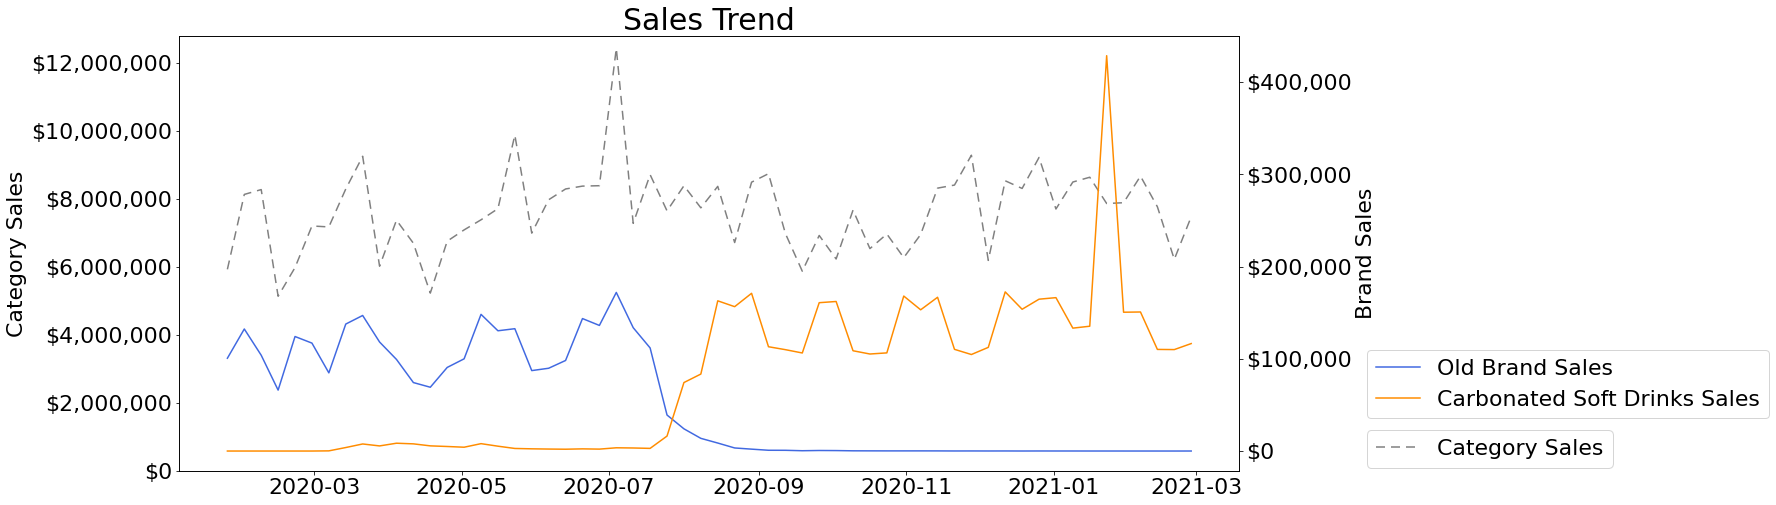

(113430.73192307692, 138918.49749999997, 7642791.51362069, 0.07806519389384414, 0.07548633264732844, 0.018115340045060137, 0.013173817329195273)
0.07618586646231351 ob_share_yago_PR
0.011917094055077621 ob_share_PR
-0.06426877240723589 share_diff_PR


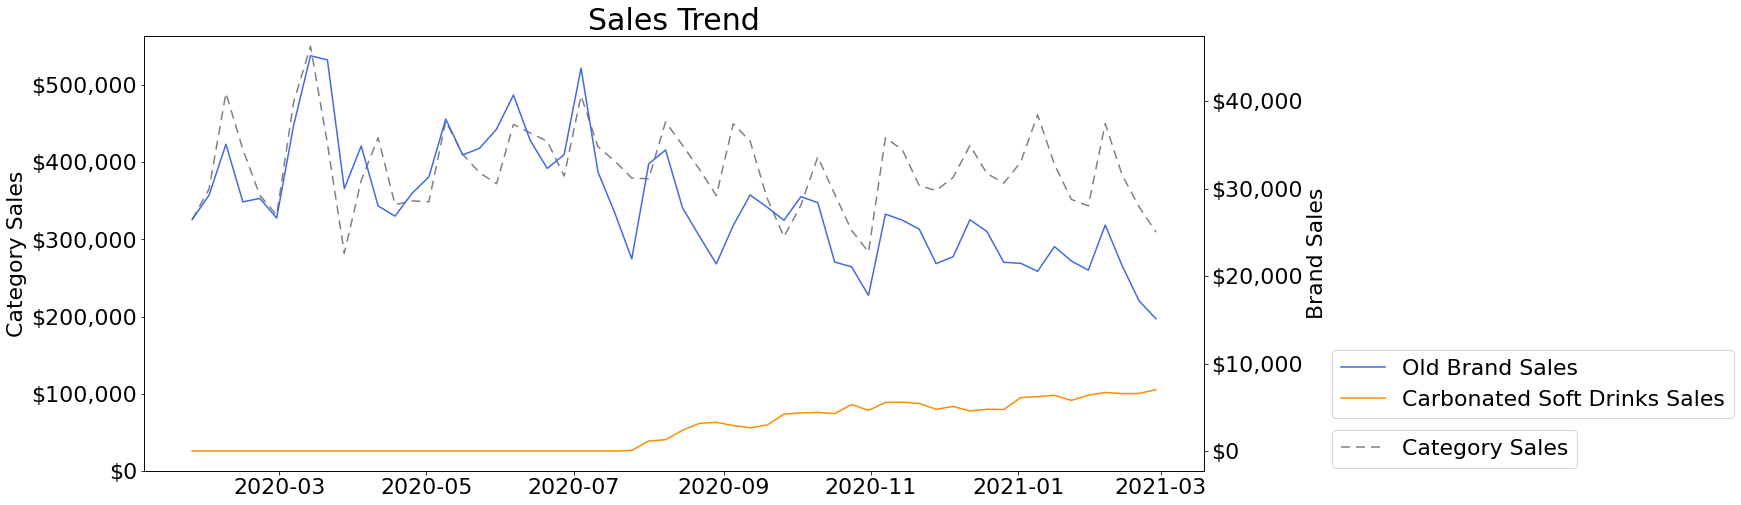

(33496.00115384615, 4542.9903125, 391321.24793103454, 0.06386066680624783, 0.17502913225834948, 0.011917094055077621, 0.07618586646231351)


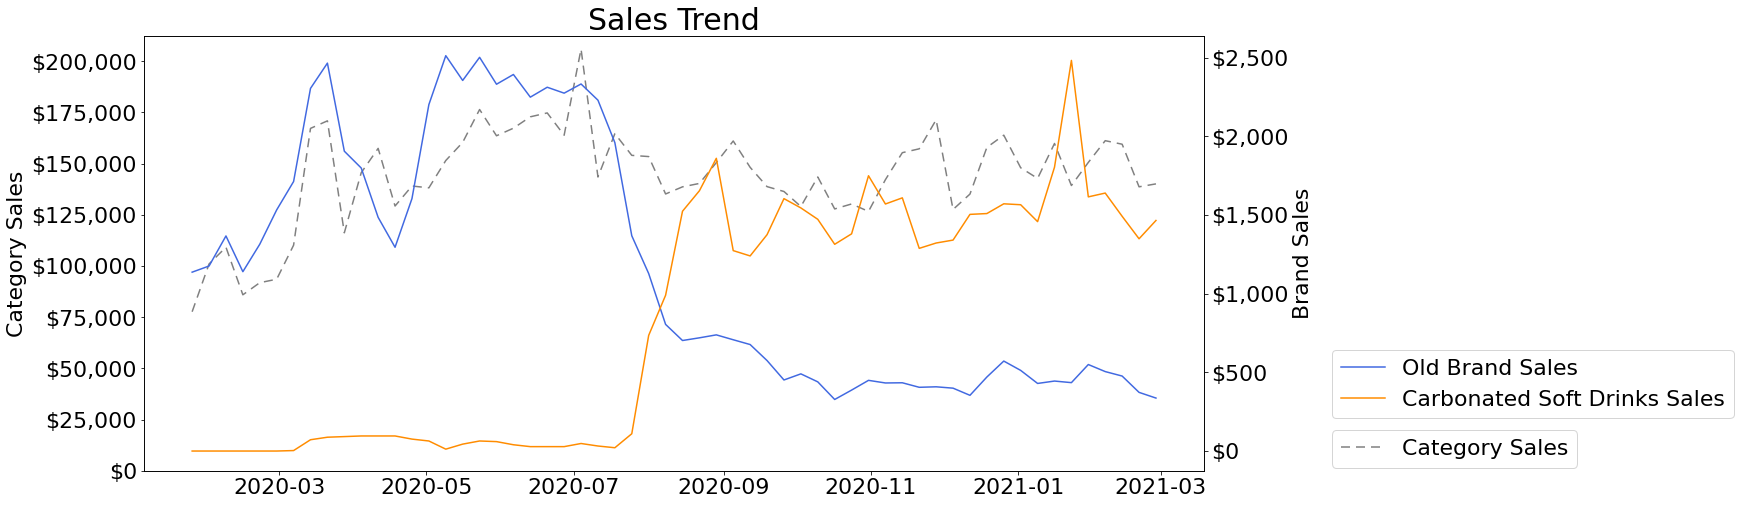

(1918.7442307692306, 1450.2693749999996, 143854.13706896553, 0.04675262695391155, 0.05812079935478089, 0.009948044050168553, 0.01747895403133501)
item_ttl (148845.4773076923, 144911.75718749998, 8177966.89862069, 0.07672359265216323, 0.0821622630864899, 0.01768174698521397, 0.016500360054787125)
----Carbonated Soft Drinks----
ob share SR new&old 0.01850482313125446
ob share new&old 0.021060012258465852
Convension Date 2020-08-16 00:00:00
Convension Date YAGO 2019-08-18 00:00:00
Convension Date 26 wks Pre 2020-02-16 00:00:00
Convension Date 26 wks Pre 2020-02-16 00:00:00


/apps_opensource/anaconda3/lib/python3.7/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


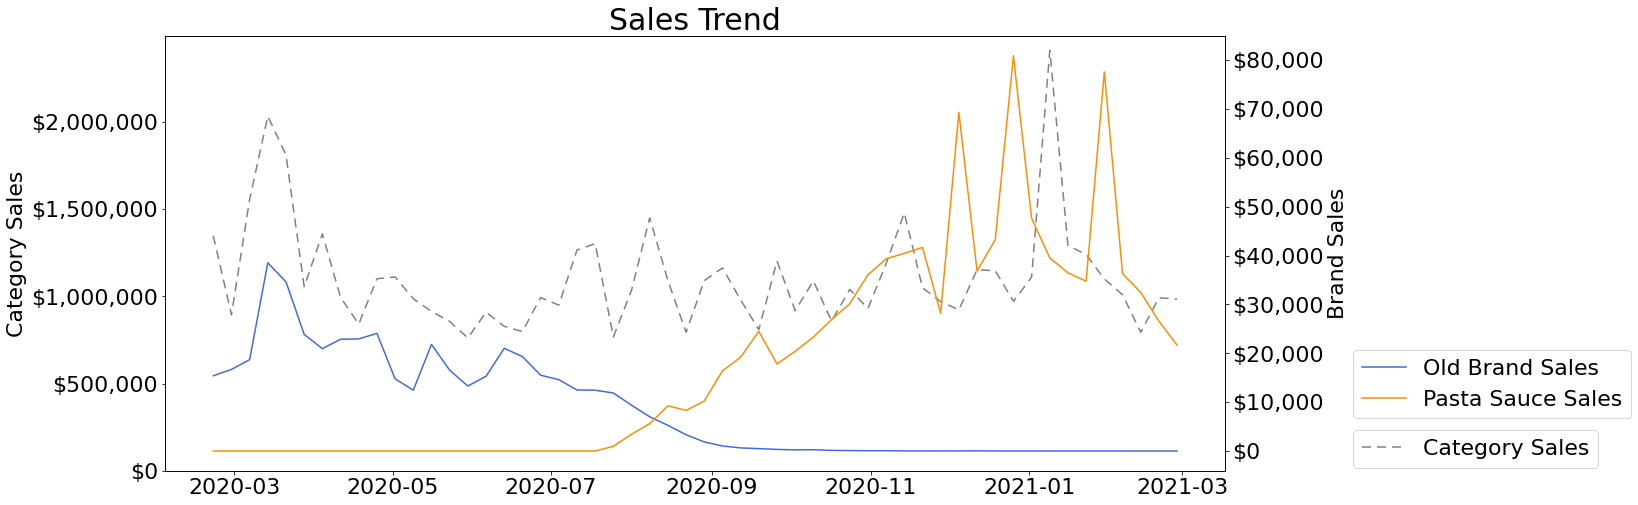

(17763.82153846154, 34517.28642857143, 1104912.0122222218, 0.05918581427874278, 0.020242809757629147, 0.03151340479006841, 0.016250772095005493)
0.18555427428490429 ob_share_yago_PR
0.16888638508074633 ob_share_PR
-0.01666788920415796 share_diff_PR


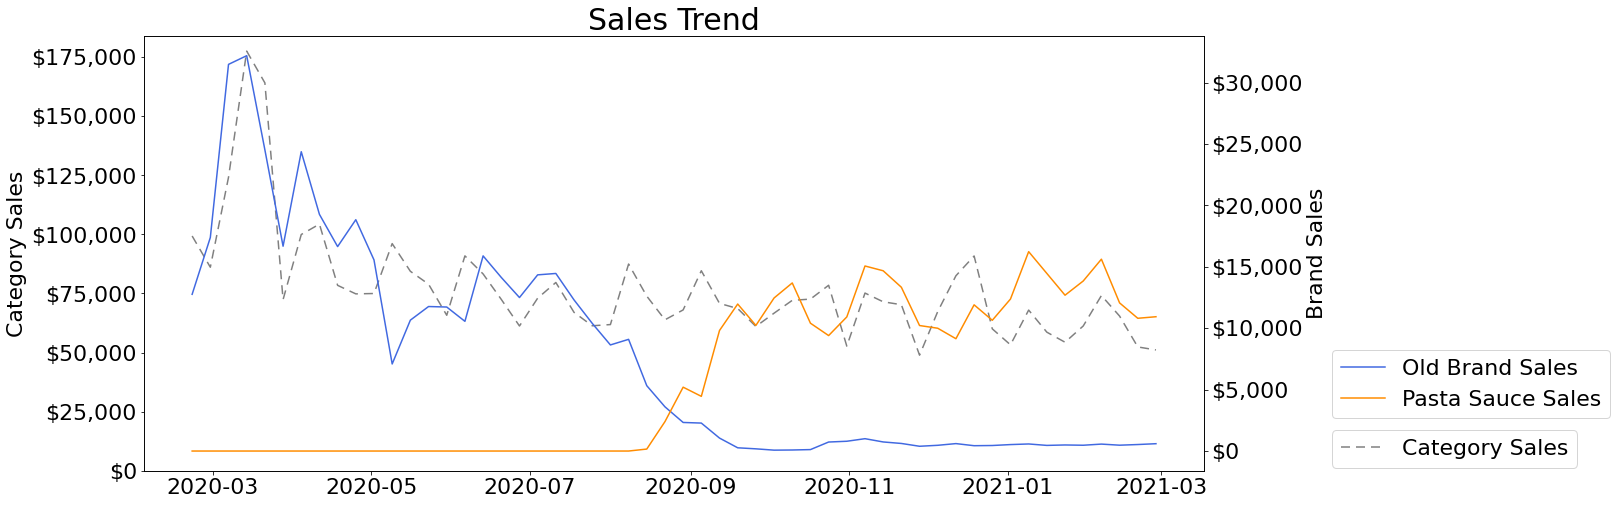

(15327.463846153849, 11246.571785714286, 76995.49277777779, 0.2764509168768245, 0.274608298307105, 0.16888638508074633, 0.18555427428490429)


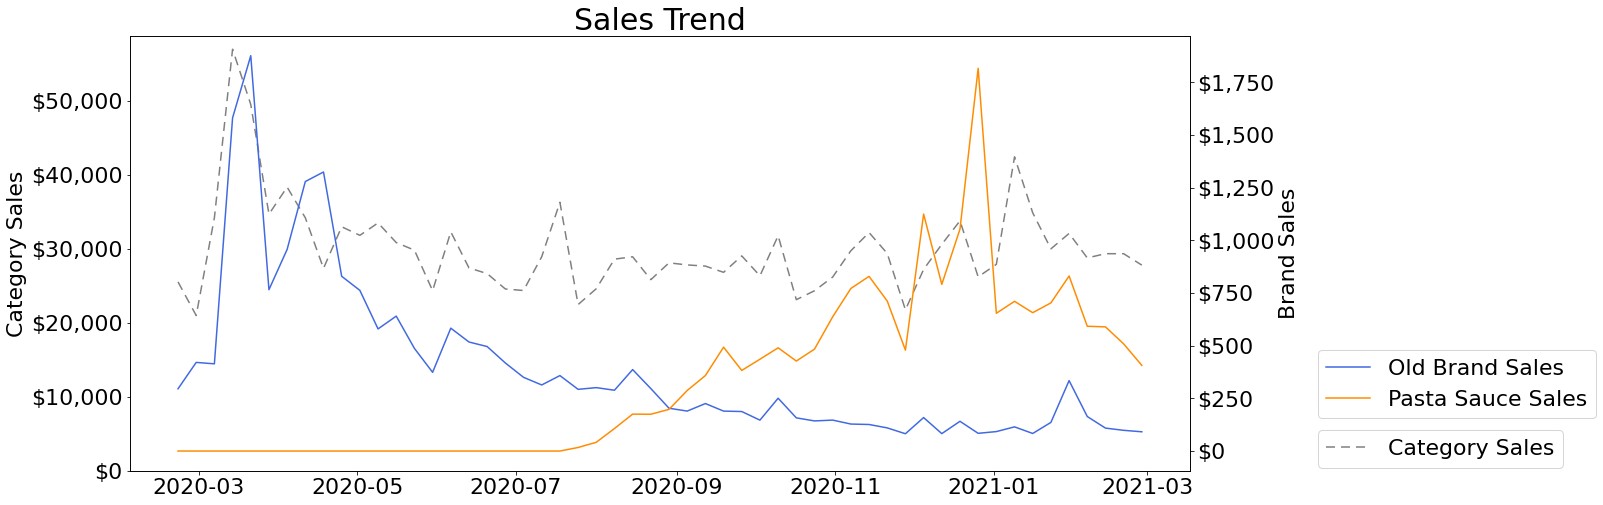

(649.8173076923077, 628.5985714285714, 30020.22925925925, 0.04175074495668471, 0.01550147919846645, 0.02171115439613019, 0.013555649148980291)
item_ttl (33741.10269230769, 46392.45678571429, 1211927.734259259, 0.07344613776026608, 0.04718136204450497, 0.03895690495132923, 0.029488288899353433)
----Pasta Sauce----
ob share SR new&old 0.03179811884478434
ob share new&old 0.039973583379688836
Convension Date 2020-08-30 00:00:00
Convension Date YAGO 2019-09-01 00:00:00
Convension Date 26 wks Pre 2020-03-01 00:00:00
Convension Date 26 wks Pre 2020-03-01 00:00:00


/apps_opensource/anaconda3/lib/python3.7/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


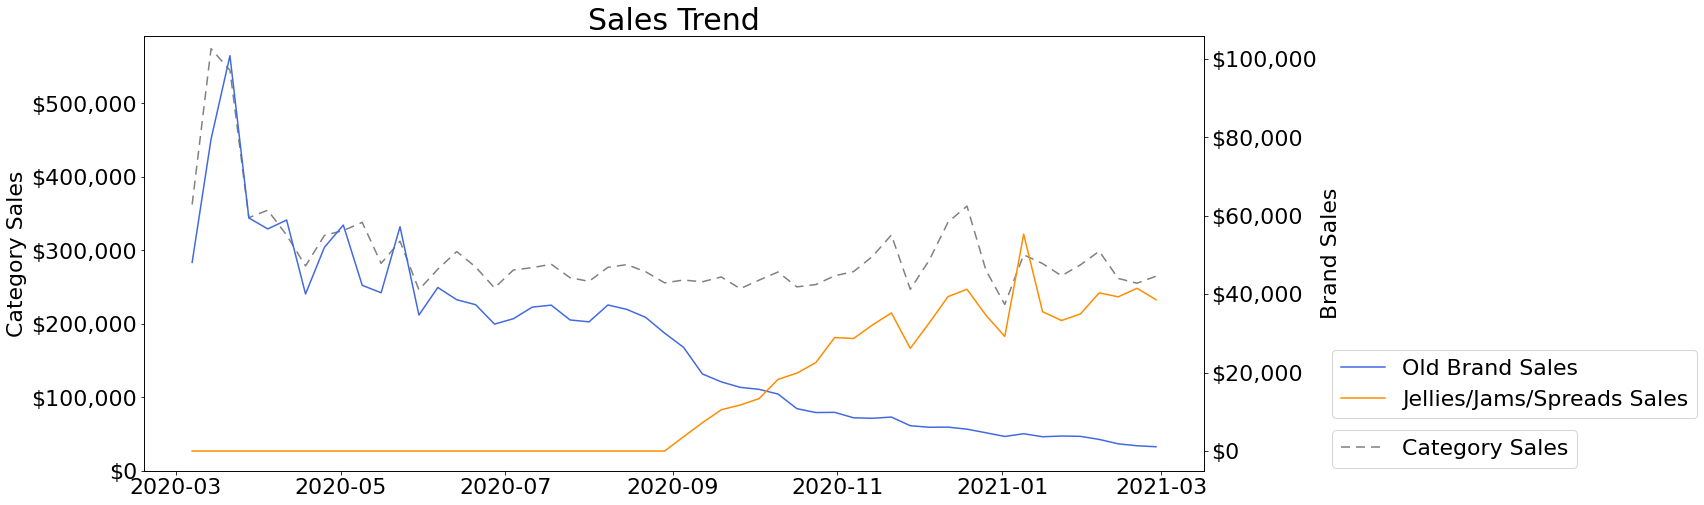

(45739.985, 29017.08923076924, 293941.80596153846, 0.1356352428128135, 0.1657080033040579, 0.10559898295005539, 0.13507095558316753)
0.5434019706059392 ob_share_yago_PR
0.3221391777119275 ob_share_PR
-0.22126279289401168 share_diff_PR


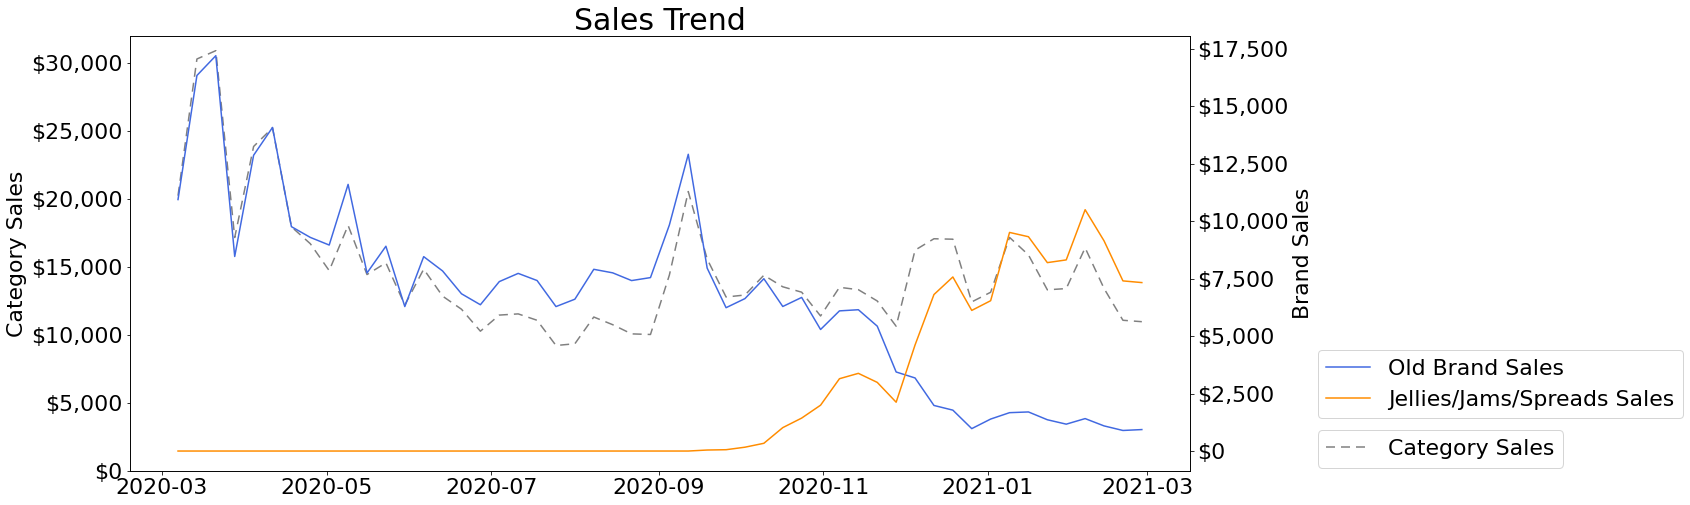

(9148.071153846153, 4538.431538461538, 14771.918269230764, 0.2924208479065594, 0.5760854151402709, 0.3221391777119275, 0.5434019706059392)


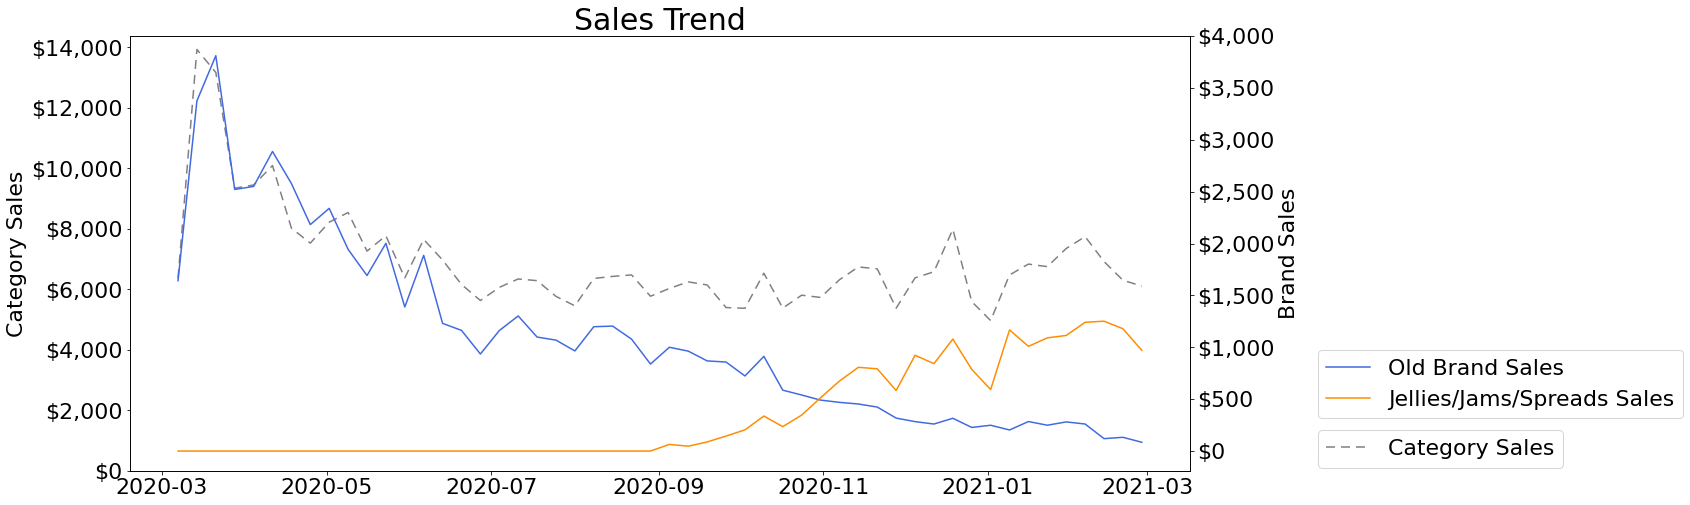

(1771.3361538461538, 695.6688461538463, 6944.480961538463, 0.13605352493325862, 0.2946382317389052, 0.11048535787516932, 0.26093064979141706)
item_ttl (56659.39230769231, 34251.189615384625, 315658.20519230765, 0.1455688819281124, 0.1925970949497614, 0.11603862692562475, 0.15630638124638624)
----Jellies/Jams/Spreads----
ob share SR new&old 0.13663032977070144
ob share new&old 0.16075674342192572
Convension Date 2020-09-06 00:00:00
Convension Date YAGO 2019-09-08 00:00:00
Convension Date 26 wks Pre 2020-03-08 00:00:00
Convension Date 26 wks Pre 2020-03-08 00:00:00


/apps_opensource/anaconda3/lib/python3.7/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


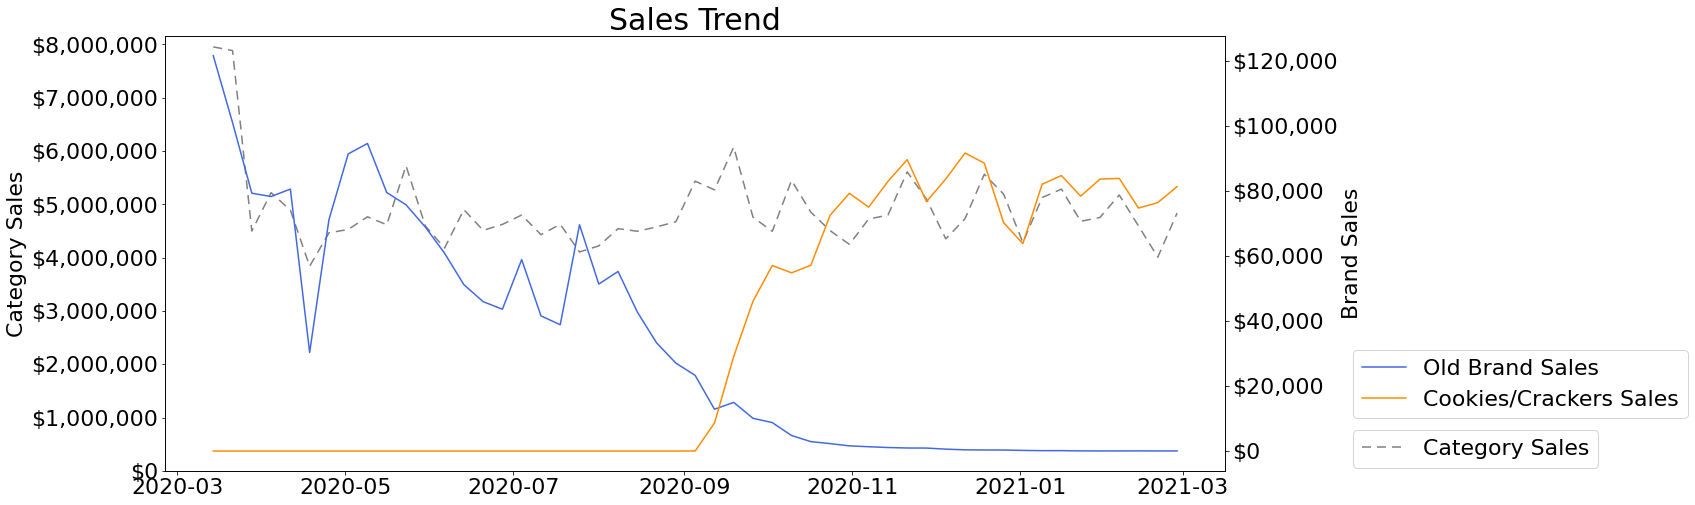

(62180.39615384614, 70920.776, 4893362.292352941, 0.026633847454679154, 0.024728691099220764, 0.014478006508209823, 0.015793614303927075)
0.11394165960553103 ob_share_yago_PR
0.031108306542626207 ob_share_PR
-0.08283335306290482 share_diff_PR


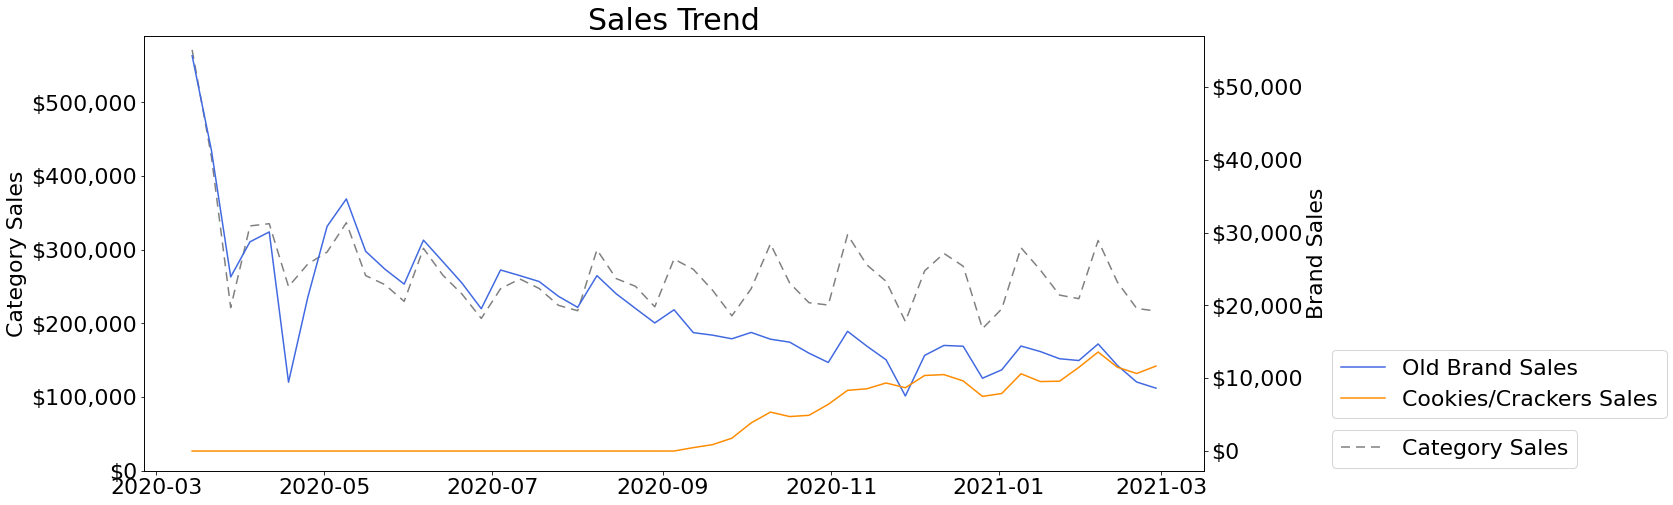

(25489.787307692306, 7913.741200000001, 268408.96392156865, 0.05523157690467536, 0.2190111554542413, 0.031108306542626207, 0.11394165960553103)


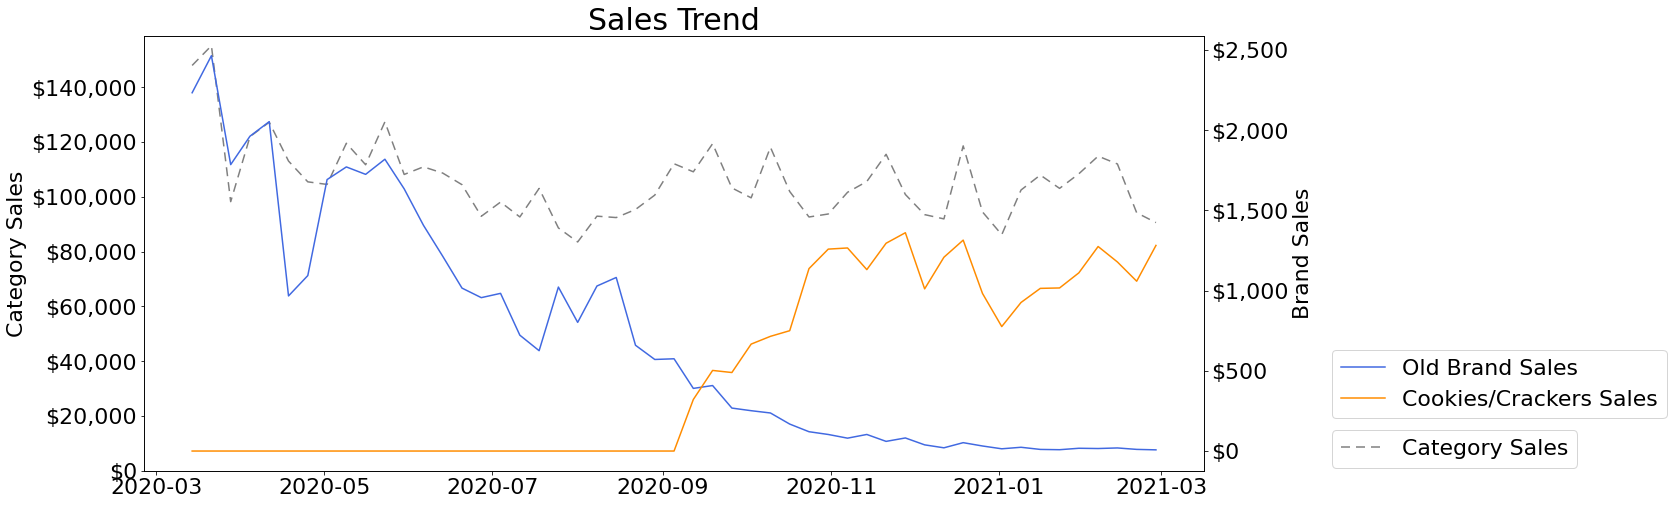

(1302.7996153846154, 1002.1303999999999, 105853.08098039217, 0.015234994573837549, 0.02085002229305844, 0.009707991843775004, 0.015847338400831183)
item_ttl (88972.98307692306, 79836.6476, 5267624.337254901, 0.028077139169555204, 0.03761523386416608, 0.01518922043588269, 0.020702861538070515)
----Cookies/Crackers----
ob share SR new&old 0.015005995663542842
ob share new&old 0.018224493144891975
Convension Date 2020-07-05 00:00:00
Convension Date YAGO 2019-07-07 00:00:00
Convension Date 26 wks Pre 2020-01-05 00:00:00
Convension Date 26 wks Pre 2020-01-05 00:00:00


/apps_opensource/anaconda3/lib/python3.7/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


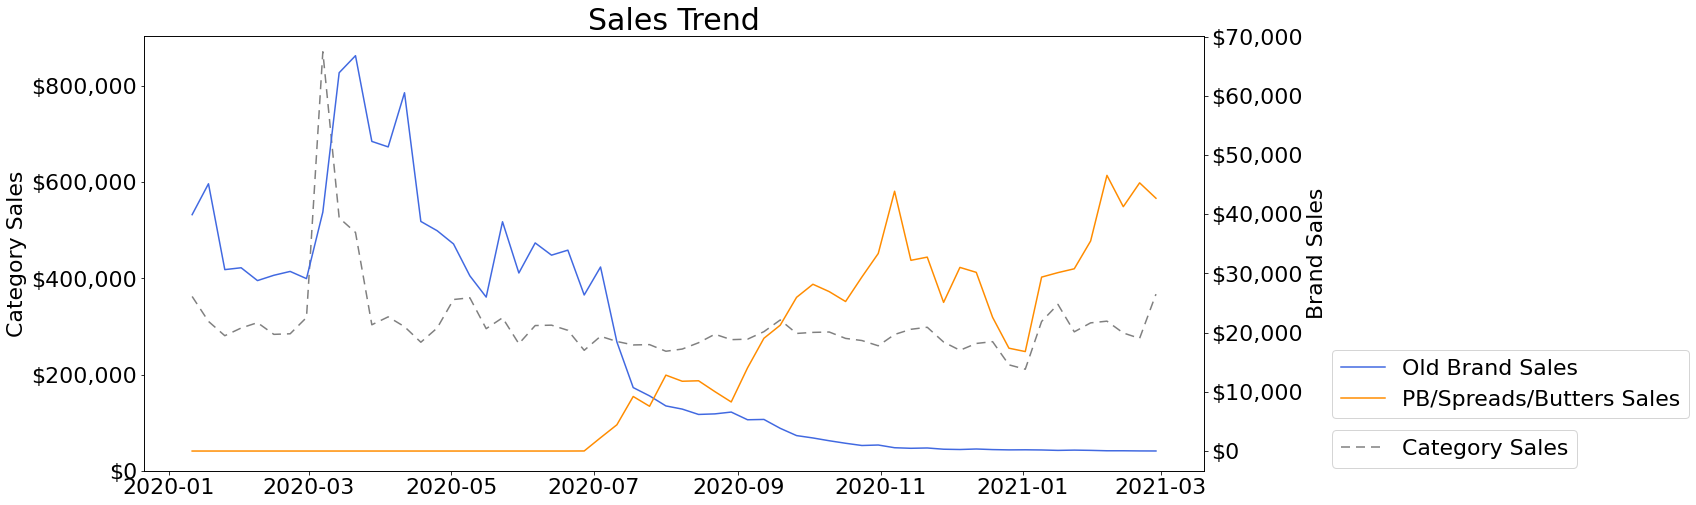

(38253.190769230765, 25081.398235294124, 305930.72449999995, 0.09812475650046866, 0.09151830659563596, 0.08965570984212821, 0.11872986050486589)
0.24976425984211378 ob_share_yago_PR
0.19441632641060258 ob_share_PR
-0.055347933431511204 share_diff_PR


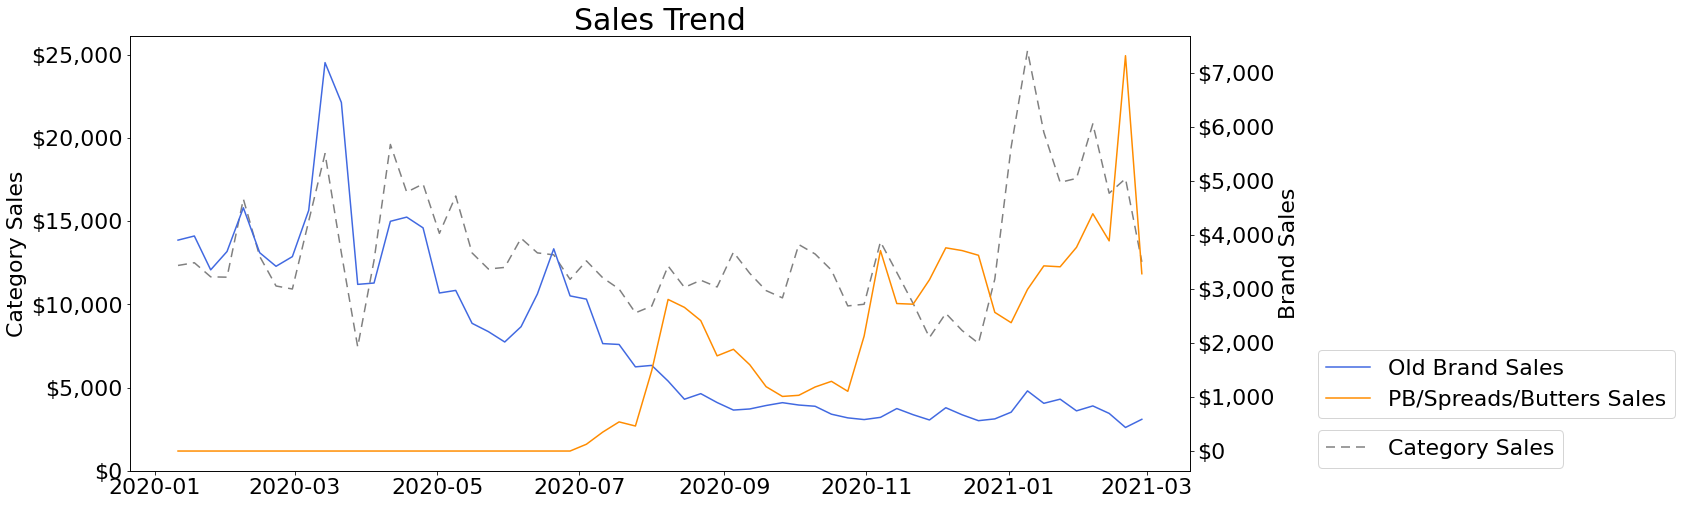

(3622.6423076923074, 2520.440588235294, 13220.378499999999, 0.1139311481611587, 0.14521409354640044, 0.19441632641060258, 0.24976425984211378)


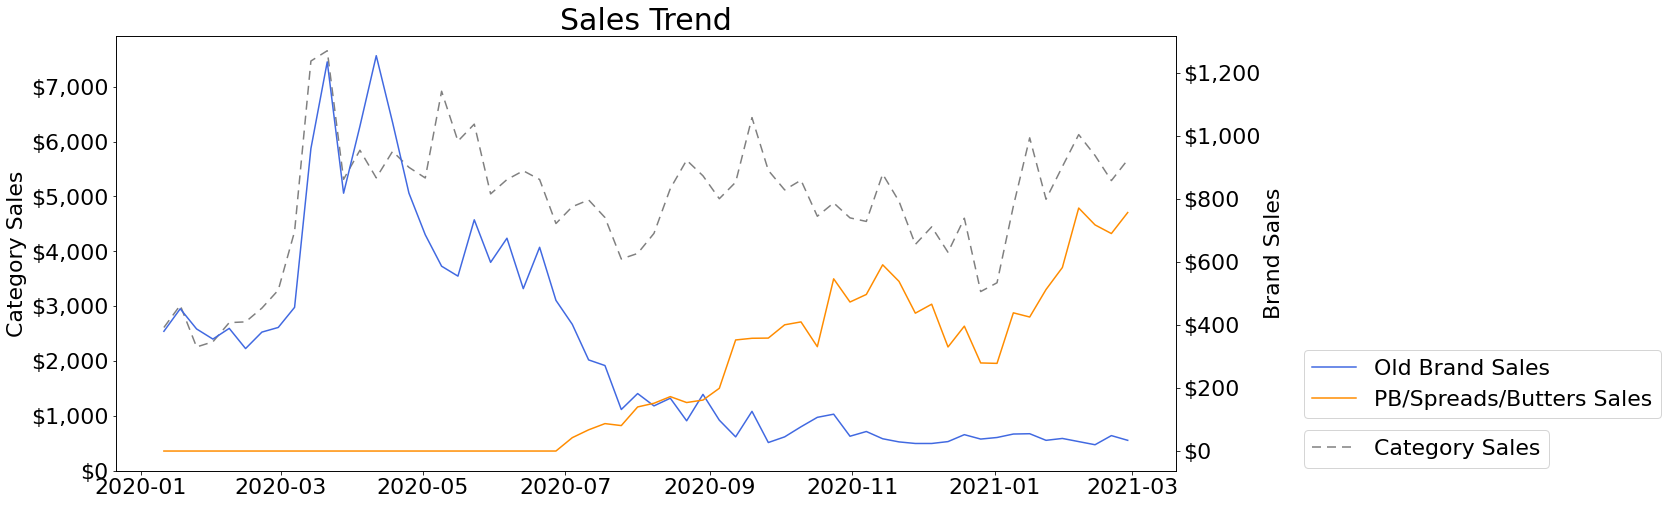

(636.1580769230768, 386.5538235294119, 4862.927166666665, 0.08141343163230043, 0.11385057777304436, 0.07846672261639842, 0.1432929198748979)
item_ttl (42511.99115384615, 27988.39264705883, 324014.0301666666, 0.09895546614518662, 0.09556652171243238, 0.09403347515582064, 0.12547918870230265)
----PB/Spreads/Butters----
ob share SR new&old 0.10019226950950204
ob share new&old 0.10721689524218884
Convension Date 2020-07-19 00:00:00
Convension Date YAGO 2019-07-21 00:00:00
Convension Date 26 wks Pre 2020-01-19 00:00:00
Convension Date 26 wks Pre 2020-01-19 00:00:00


/apps_opensource/anaconda3/lib/python3.7/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


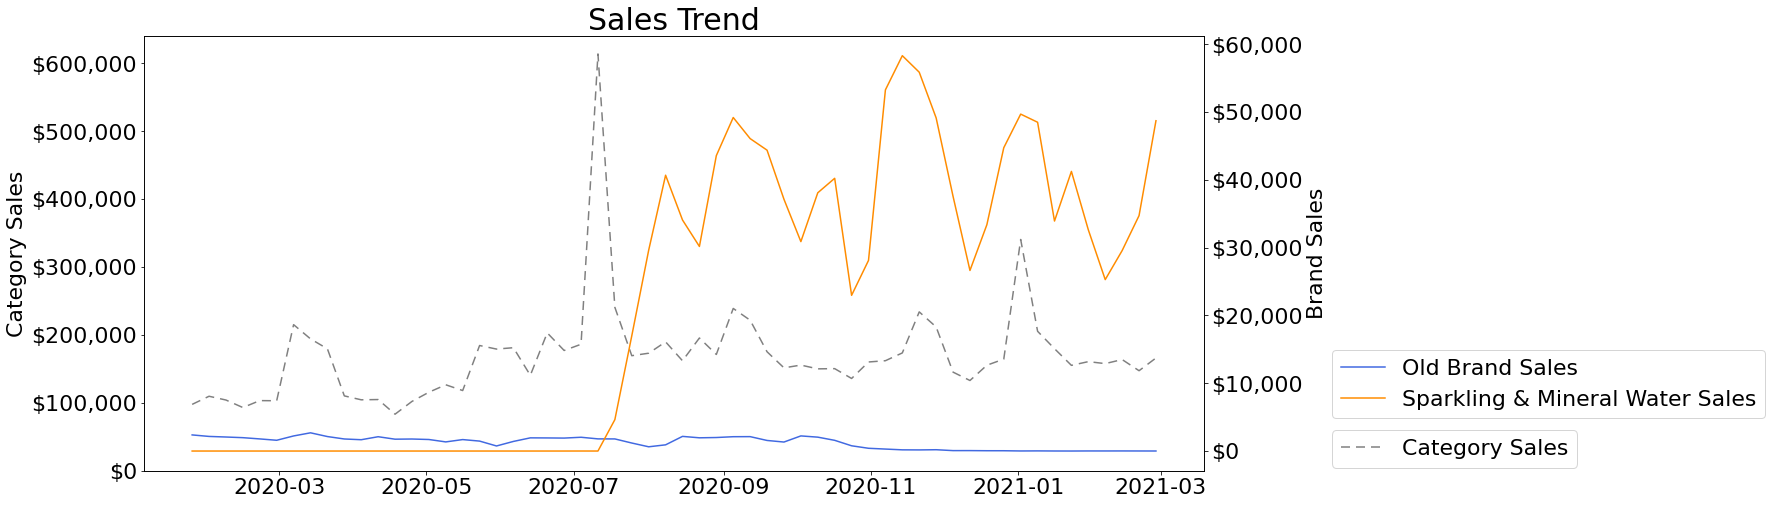

(1839.8576923076928, 38614.13843749999, 169538.81706896547, 0.2982918541255656, 0.06523437600724052, 0.21833716765087471, 0.02647030605738367)
0.9887036755771568 ob_share_yago_PR
0.9881407344460176 ob_share_PR
-0.0005629411311391941 share_diff_PR


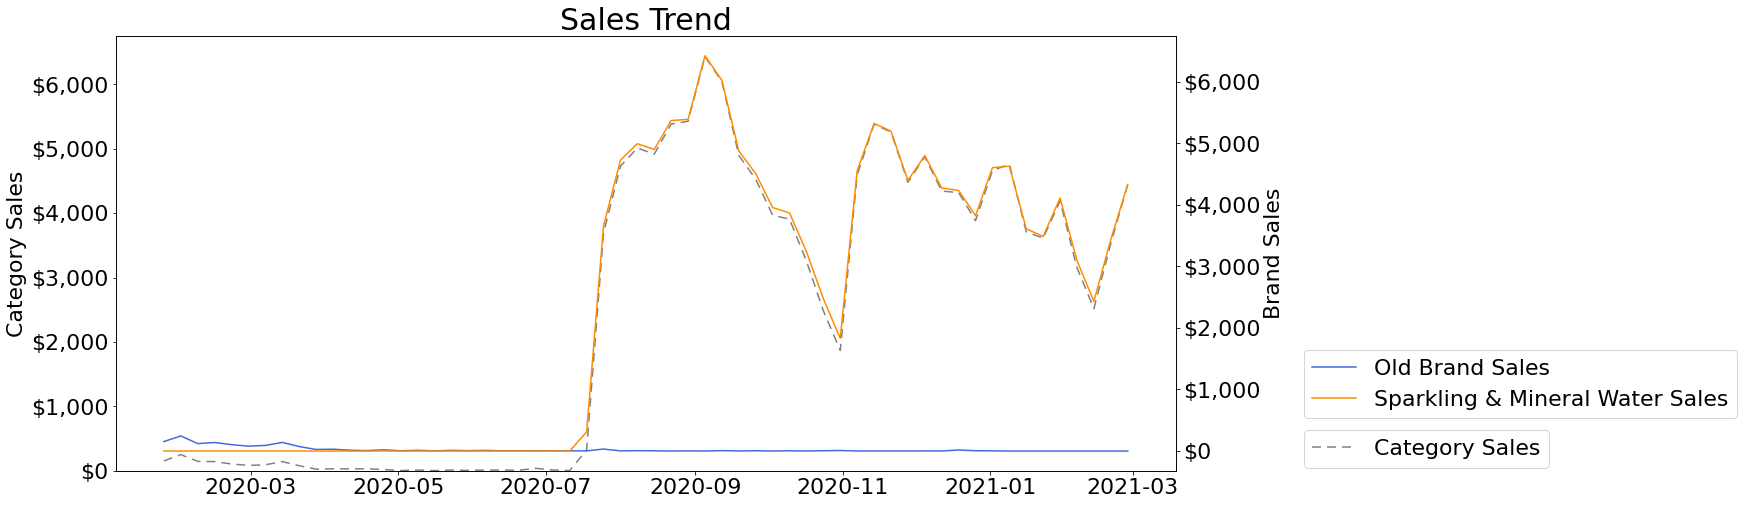

(50.247307692307714, 4268.5990624999995, 2414.0446551724144, 0.9814531394740021, 0.99634047167254, 0.9881407344460176, 0.9887036755771568)


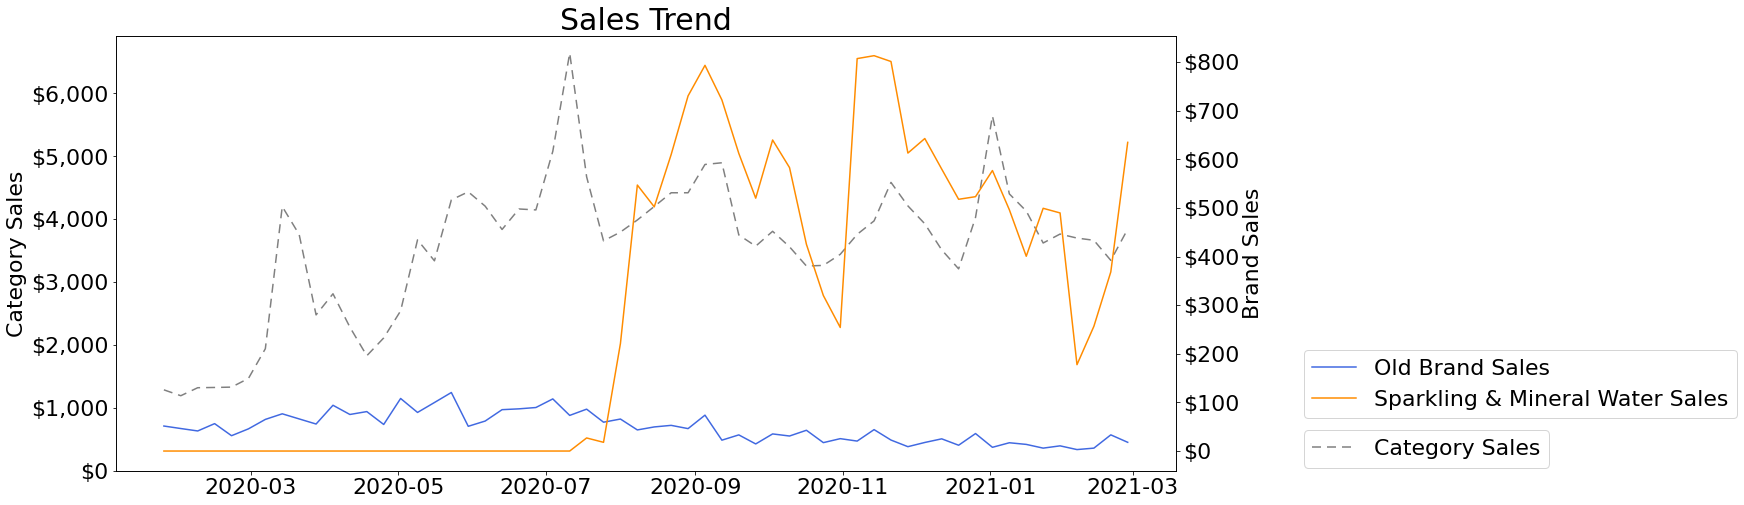

(72.66384615384617, 521.8528125, 3562.23, 0.1945534752856994, 0.062444378522693564, 0.13230154340669412, 0.029575200314097775)
item_ttl (1962.7688461538467, 43404.59031249999, 175515.0917241379, 0.3191320098643816, 0.07100318919069537, 0.2344675833934457, 0.028249139825739573)
----Sparkling & Mineral Water----
ob share SR new&old 0.22259788722094742
ob share new&old 0.23871064502515077
Convension Date 2020-08-16 00:00:00
Convension Date YAGO 2019-08-18 00:00:00
Convension Date 26 wks Pre 2020-02-16 00:00:00
Convension Date 26 wks Pre 2020-02-16 00:00:00


/apps_opensource/anaconda3/lib/python3.7/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


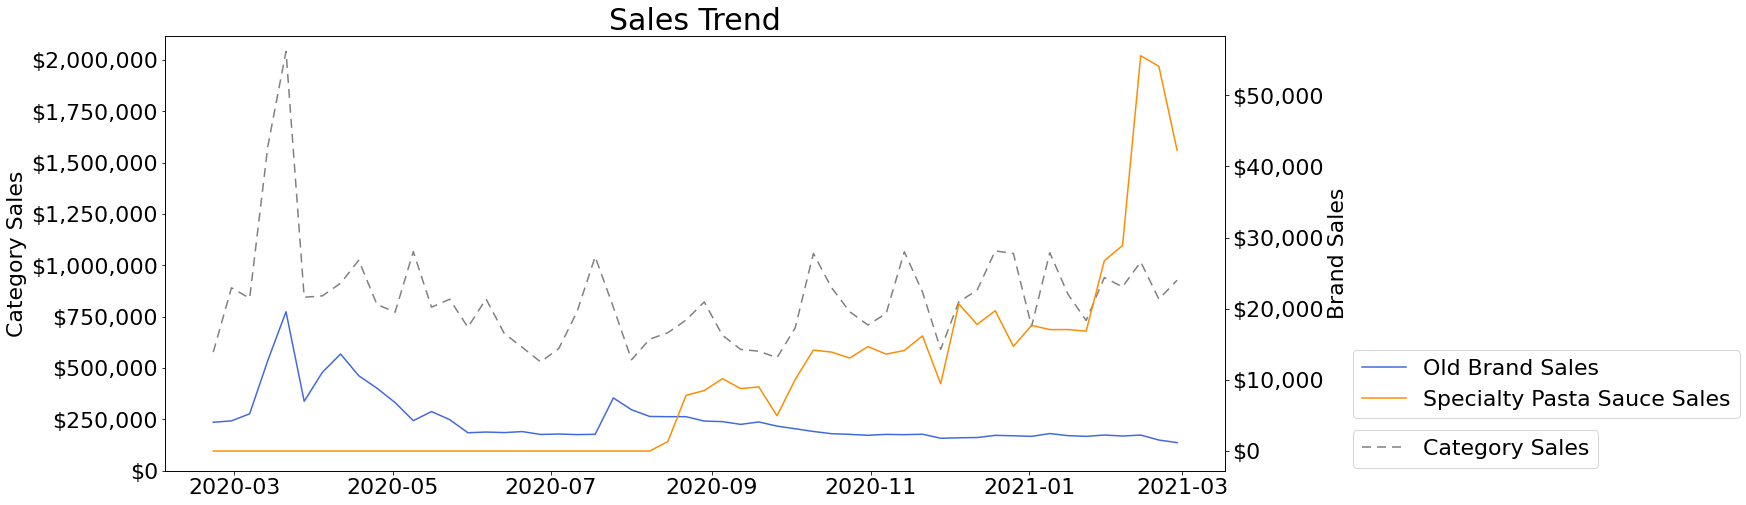

(6187.163461538458, 18486.98321428572, 840759.7948148148, 0.05421374849404995, 0.007738288734278501, 0.022347364920007332, 0.005303186345896174)
0.33690895570630947 ob_share_yago_PR
0.14424322201519907 ob_share_PR
-0.1926657336911104 share_diff_PR


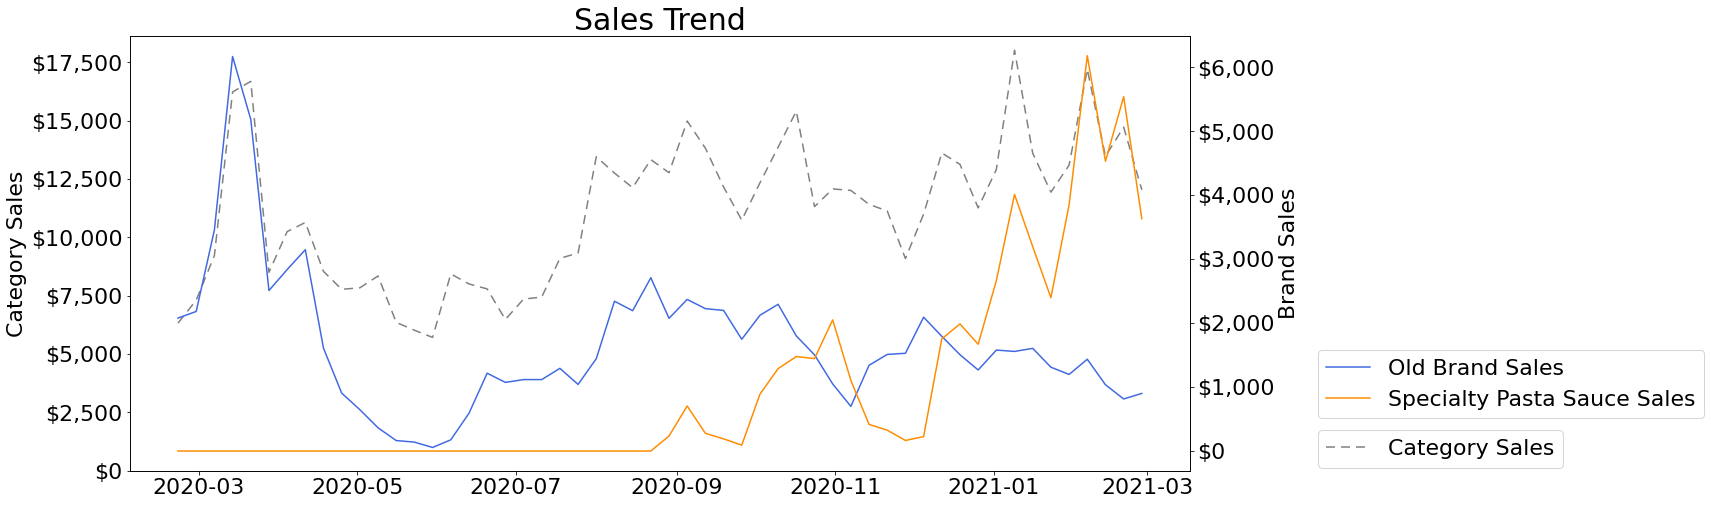

(1732.887692307692, 1867.9517857142857, 11124.699444444444, 0.22969665373638123, 0.2673519893394251, 0.14424322201519907, 0.33690895570630947)


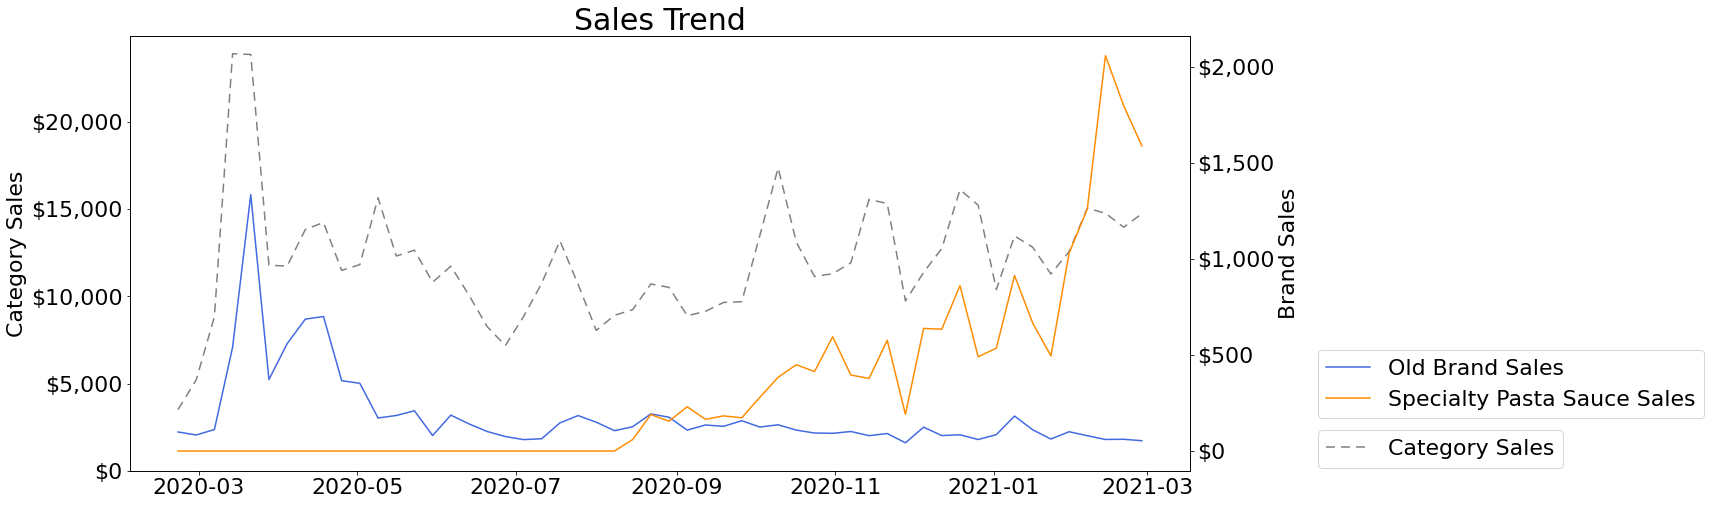

(276.9357692307693, 633.6692857142858, 12051.128518518519, 0.11779123619522622, 0.05290616012306869, 0.05038396076950723, 0.044662803490808256)
item_ttl (8196.98692307692, 20988.60428571429, 863935.6227777778, 0.05950477660690678, 0.011228866158392787, 0.02461190956805379, 0.008046185781678757)
----Specialty Pasta Sauce----
ob share SR new&old 0.02547131166468547
ob share new&old 0.02966053059611569
Convension Date 2020-09-13 00:00:00
Convension Date YAGO 2019-09-15 00:00:00
Convension Date 26 wks Pre 2020-03-15 00:00:00
Convension Date 26 wks Pre 2020-03-15 00:00:00


/apps_opensource/anaconda3/lib/python3.7/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


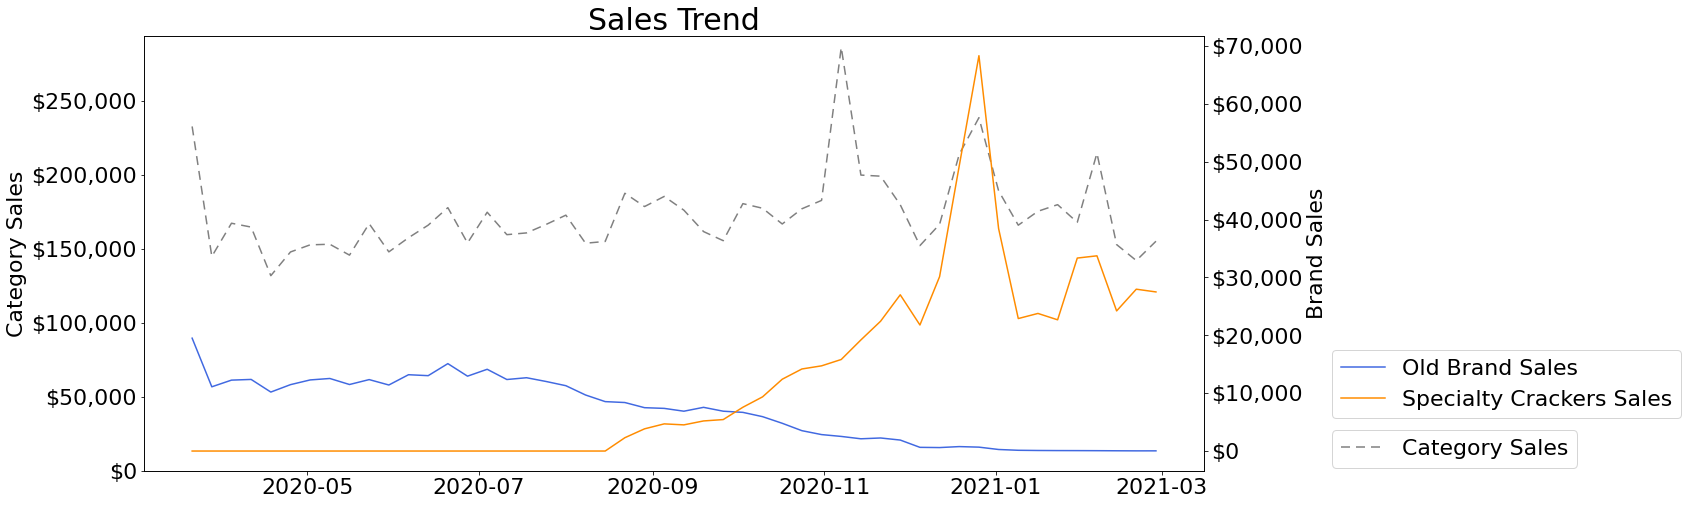

(11614.643076923074, 24055.10875, 173131.765, 0.2147579269545911, 0.13351934943544258, 0.13187468707685557, 0.08055362532947631)
0.02469074345644541 ob_share_yago_PR
0.012826497541145324 ob_share_PR
-0.011864245915300086 share_diff_PR


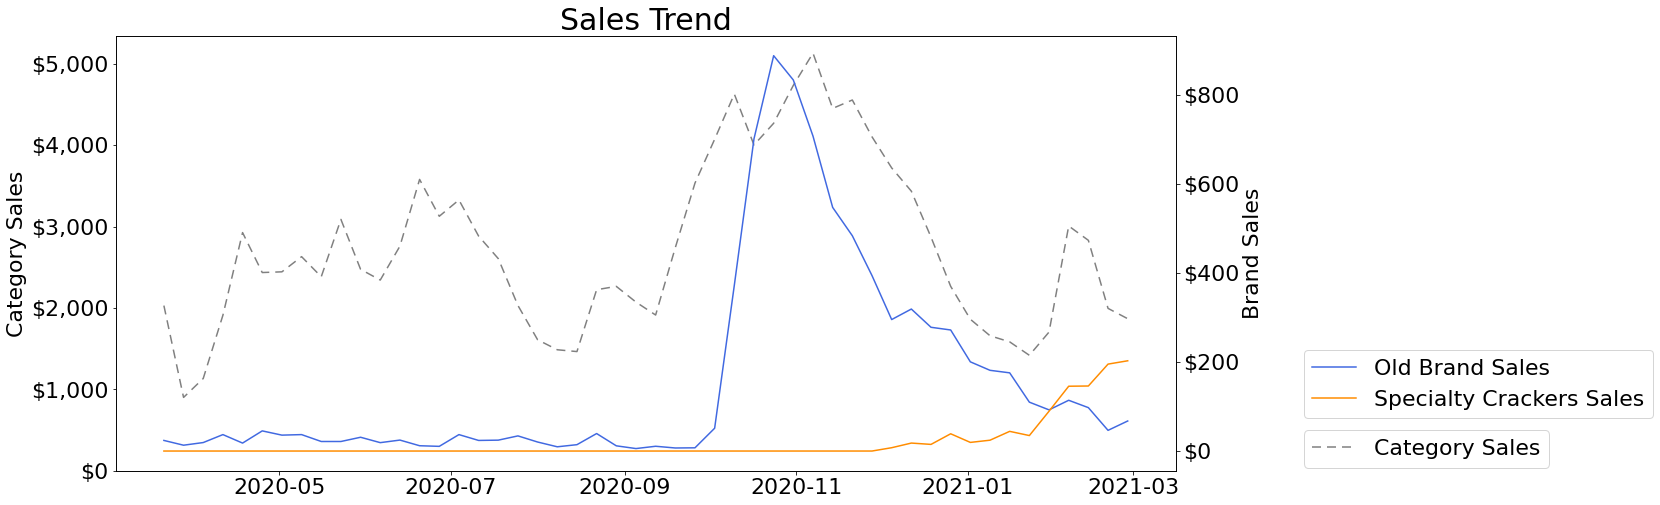

(23.018461538461533, 40.84916666666667, 2729.5669999999996, 0.011731764372297442, 0.02338236544511521, 0.012826497541145324, 0.02469074345644541)


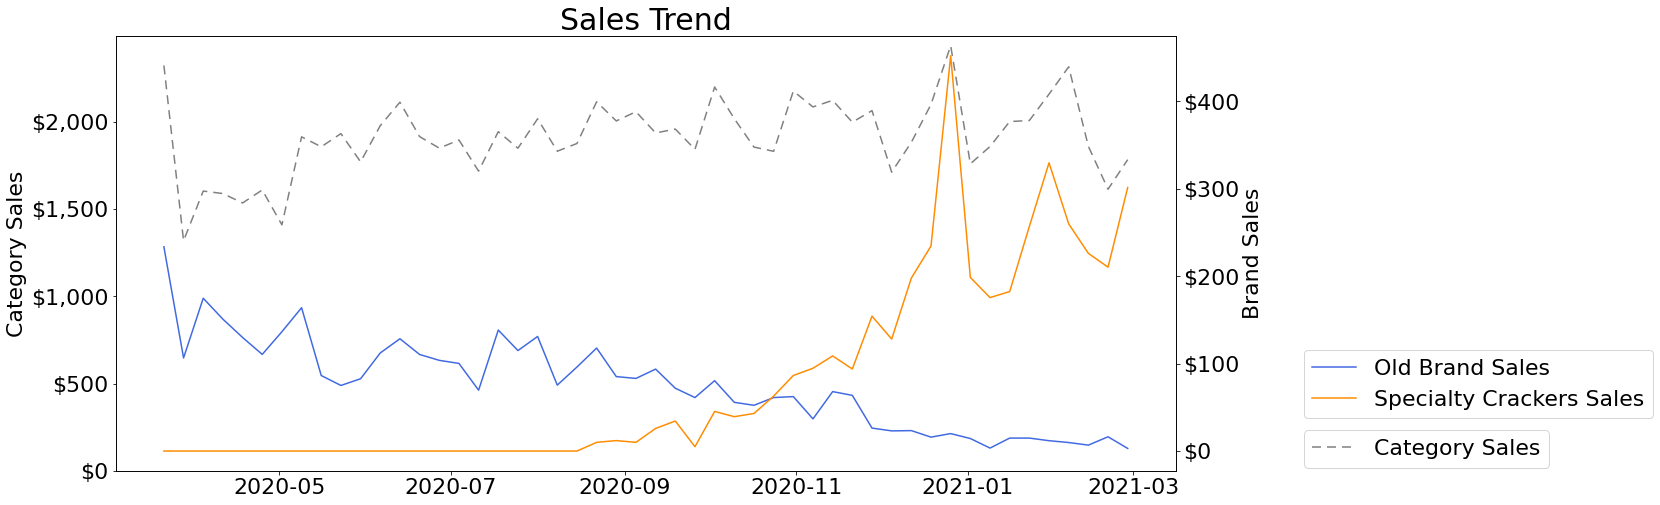

(115.84500000000001, 163.44916666666668, 1912.3525999999997, 0.1427499061678969, 0.2777890672627515, 0.08232827254348186, 0.18812948492137876)
item_ttl (11753.506538461535, 24259.40708333333, 177773.68460000004, 0.20687911829698732, 0.13008036506588552, 0.12932906667890212, 0.08008679934409968)
----Specialty Crackers----
ob share SR new&old 0.1434060040999886
ob share new&old 0.14233210005097055
Convension Date 2020-10-18 00:00:00
Convension Date YAGO 2019-10-20 00:00:00
Convension Date 26 wks Pre 2020-04-19 00:00:00
Convension Date 26 wks Pre 2020-04-19 00:00:00


/apps_opensource/anaconda3/lib/python3.7/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


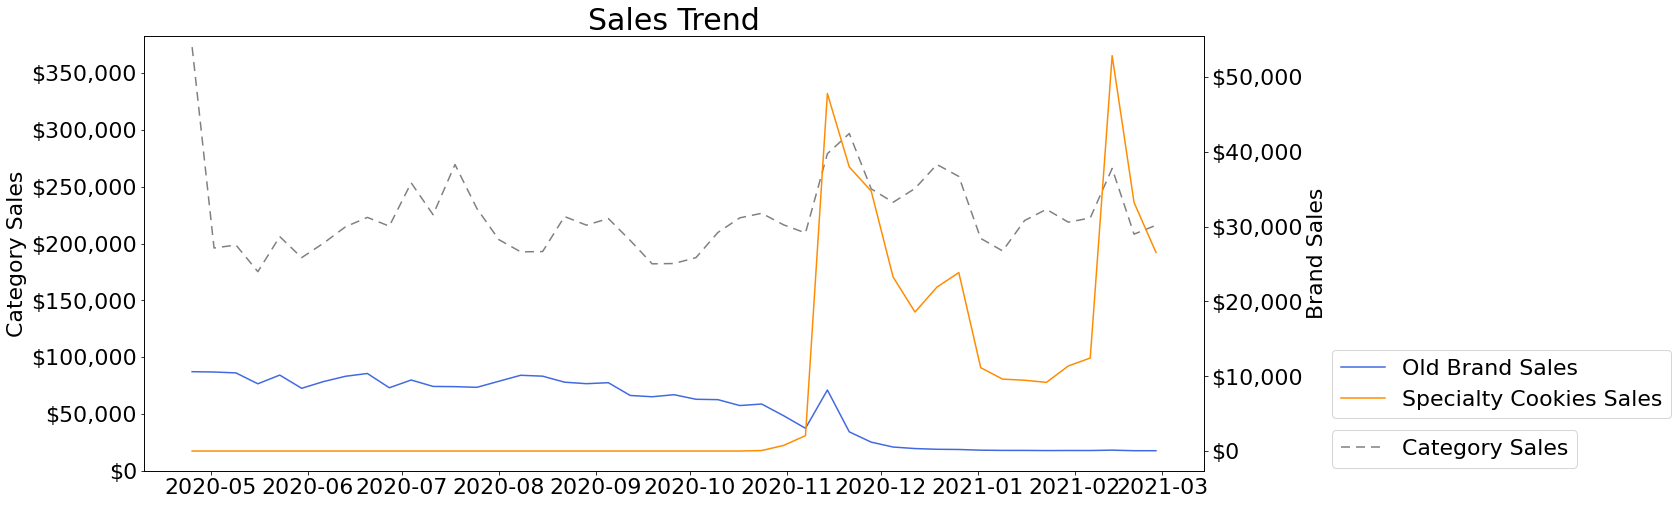

(8903.03153846154, 20367.935789473682, 223962.0415555555, 0.09452540530841365, 0.08552249596379968, 0.08656773281067963, 0.07607633570831297)
0.010847844704538968 ob_share_yago_PR
0.04317944216308657 ob_share_PR
0.032331597458547606 share_diff_PR


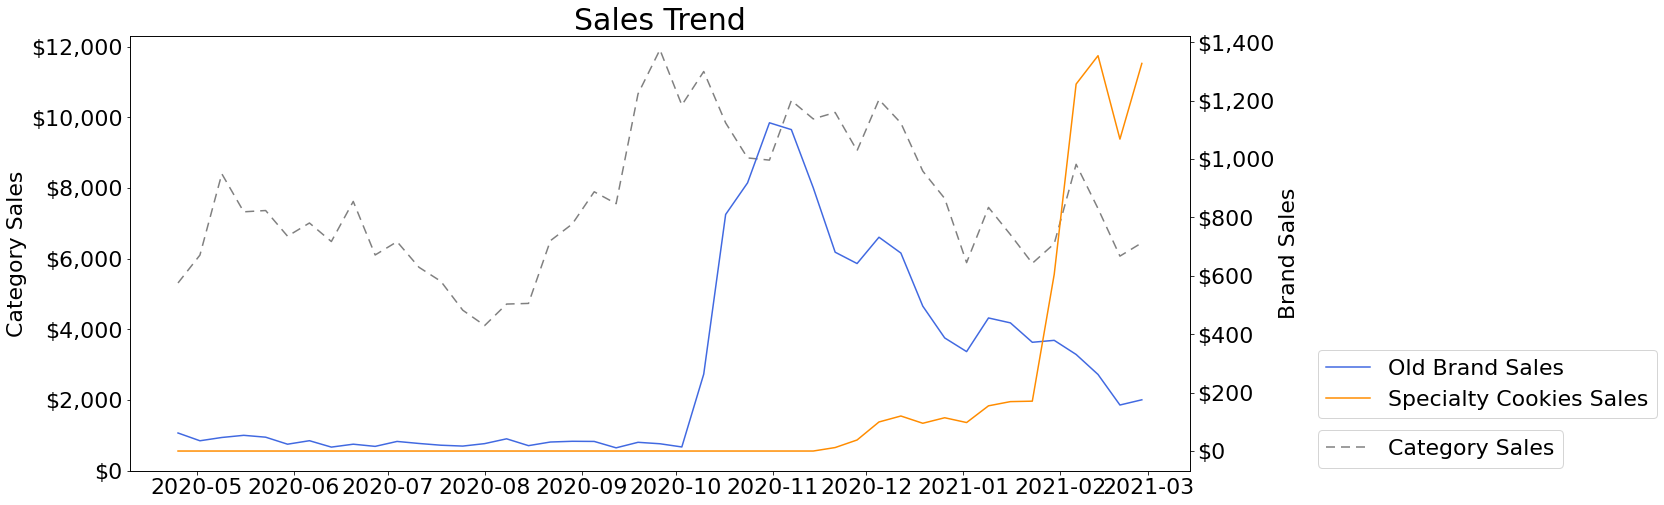

(68.76538461538462, 351.67842105263156, 7596.848666666666, 0.030761425524424842, 0.008968787824672104, 0.04317944216308657, 0.010847844704538968)


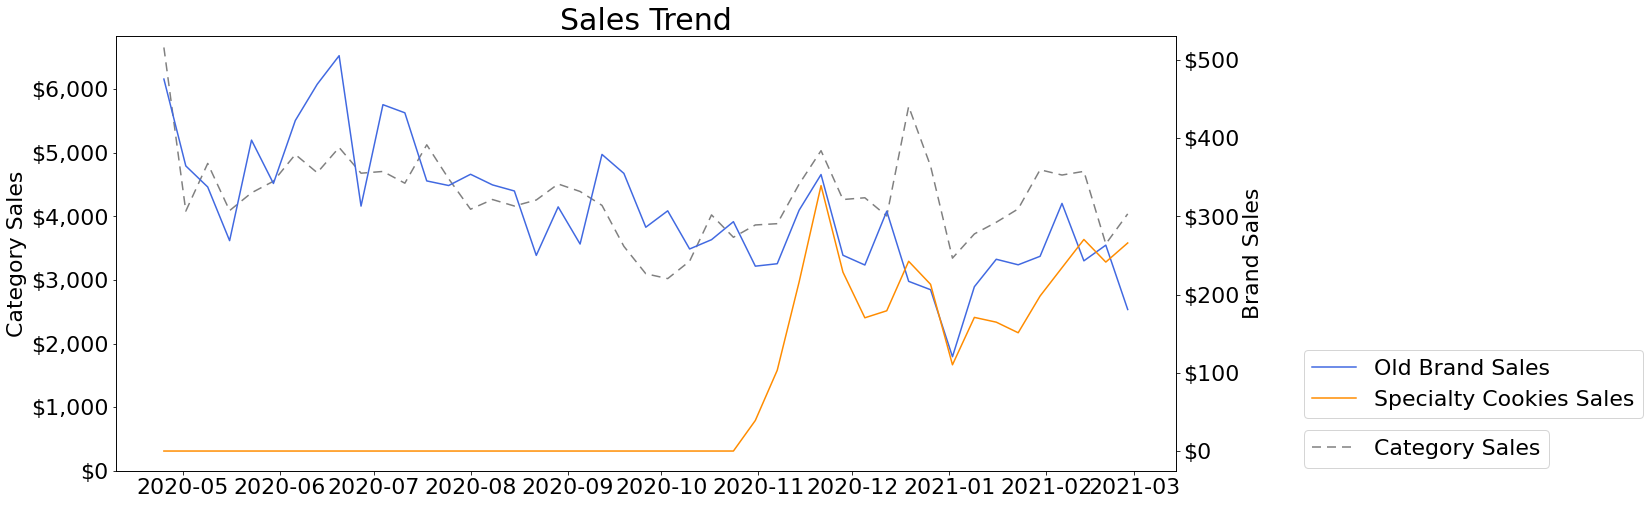

(352.47115384615387, 186.26894736842107, 4325.348222222223, 0.04498745575145204, 0.04187604690117253, 0.043777828796034556, 0.07847132409266136)
item_ttl (9324.26807692308, 20905.883157894736, 235884.23844444437, 0.08976646966810815, 0.08195986422644412, 0.08440591486784178, 0.07443670485088845)
----Specialty Cookies----
ob share SR new&old 0.09282178983311215
ob share new&old 0.09359567205654486


/apps_opensource/anaconda3/lib/python3.7/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [31]:
document = Document()
section = document.sections[0]
header = section.header
paragraph = header.paragraphs[0]
if brand_flag=='p':
    paragraph.add_run().add_picture('/sasuser/ASRetail/emmaz/wf_ob_wkly_sales_reports/logo2.PNG',width=Inches(6))
    brand_text='Paperbird'
else:
    paragraph.add_run().add_picture('/sasuser/ASRetail/emmaz/wf_ob_wkly_sales_reports/logo1.PNG',width=Inches(6))
    brand_text='Bowl&Basket'
    
# for i in [26]:
for i in range_list:

    conv_date_gp = obupcs.loc[obupcs.grp_num == i].Conv_Date.iloc[0]
    conv_dt_yago = conv_date_gp - timedelta(days=364)
    start_date = conv_date_gp -timedelta(days=182)

    print('Convension Date',conv_date_gp)
    print('Convension Date YAGO',conv_dt_yago)
    print('Convension Date 26 wks Pre',start_date)
    print('Convension Date 26 wks Pre',start_date)

    idx = pd.date_range(start_date, stop_date, freq="W-SAT")

    brand_text = obupcs.loc[obupcs.grp_num == i].productname.iloc[0]
    productname=upcs[upcs['Group Number']==i].reset_index()['productname'][0]
    division = obupcs.loc[obupcs.grp_num == i].Division.reset_index(drop = True)[0]
    
    title=str(productname)+str(': Catalina/Wakefern POS ')+str(start_date)[:10]+str(' to ')+str(stop_date)[:10] 
    
    product_list.append(productname)
    grp_num_list.append(i)
    division_list.append(division)
    #########################################################################################     
    ###################################### 1. ShopRite ######################################
    ######################################################################################### 
    #shop rite table: shoprite_sales_upc & shoprite_sales_cat
    #LAST YEAR
    df_upc_ly_SR = shoprite_sales_upc.loc[(shoprite_sales_upc.grpnum==i)\
                                          &(shoprite_sales_upc.index >= conv_dt_yago)\
                                          &(shoprite_sales_upc.index <= stop_dt_yago)]\
                                          [['old_sales_ly', 'old_units_ly']]\
                                          .sort_index()

    df_cat_ly_SR = shoprite_sales_cat.loc[(shoprite_sales_cat.grpnum==i)\
                                            &(shoprite_sales_cat.index >= conv_dt_yago)\
                                            &(shoprite_sales_cat.index <= stop_dt_yago)]\
                                             [['cat_sales_ly','cat_units_ly']]\
                                             .sort_index()
    # average old brand sales share
    # from conversion date YAGO to stop date YAGO
    ob_share_yago_SR = df_upc_ly_SR['old_sales_ly'].sum()/df_cat_ly_SR['cat_sales_ly'].sum()
    ob_uni_share_yago_SR = df_upc_ly_SR['old_units_ly'].sum()/df_cat_ly_SR['cat_units_ly'].sum()
    #########################################################################################################
    #THIS YEAR
    df_upc_ty_SR = shoprite_sales_upc.loc[(shoprite_sales_upc.grpnum==i)\
                                          &(shoprite_sales_upc.index >= conv_date_gp)\
                                          &(shoprite_sales_upc.index <= stop_date)]\
                                          [['new_sales_ty','old_sales_ty', 'new_units_ty', 'old_units_ty']]\
                                          .sort_index()
    
    df_cat_ty_SR = shoprite_sales_cat.loc[(shoprite_sales_cat.grpnum==i)\
                                        &(shoprite_sales_cat.index >= conv_date_gp)\
                                        &(shoprite_sales_cat.index <= stop_date)]\
                                        [['cat_sales_ty','cat_units_ty']]\
                                        .sort_index()
    
    # average new brand sales share
    # from conversion date to stop date
    ob_share_SR = df_upc_ty_SR['new_sales_ty'].sum()/df_cat_ty_SR['cat_sales_ty'].sum()
    ob_uni_share_SR = df_upc_ty_SR['new_units_ty'].sum()/df_cat_ty_SR['cat_units_ty'].sum()
    
    share_diff_SR = ob_share_SR-ob_share_yago_SR

    ######################################################################################
    #GRAPHING
    date_series= pd.Series(idx)

    new_sales_SR = shoprite_sales_upc.loc[(shoprite_sales_upc.grpnum==i)\
                                          &(shoprite_sales_upc.index >= start_date)\
                                          &(shoprite_sales_upc.index <= stop_date)]\
                                          .sort_index()['new_sales_ty'].reindex(idx, fill_value=0)
    
    old_sales_SR = shoprite_sales_upc.loc[(shoprite_sales_upc.grpnum==i)\
                                          &(shoprite_sales_upc.index >= start_date)\
                                          &(shoprite_sales_upc.index <= stop_date)]\
                                          .sort_index()['old_sales_ty'].reindex(idx, fill_value=0)
    
    cat_sales_SR = shoprite_sales_cat.loc[(shoprite_sales_cat.grpnum==i)\
                                            &(shoprite_sales_cat.index >= start_date)\
                                            &(shoprite_sales_cat.index <= stop_date)]\
                                             .sort_index()['cat_sales_ty'].reindex(idx, fill_value=0)

    line_graph(new_sales_SR,old_sales_SR,cat_sales_SR,date_series,'SR')


    ###################################################################################
    # average old sales from 26 wks prior conversion to convention date 
    before_conv_old_SR = shoprite_sales_upc.loc[(shoprite_sales_upc.grpnum==i)\
                                          &(shoprite_sales_upc.index >= start_date)\
                                          &(shoprite_sales_upc.index < conv_date_gp)]\
                                          [['old_sales_ty']]\
                                          .sort_index()
    avg_old_sales_SR = np.mean(before_conv_old_SR['old_sales_ty'])

    # average new sales from conversion 
    avg_new_sales_SR = np.mean(df_upc_ty_SR['new_sales_ty'])

    # average category sales from 26 wks prior luanch to stop date
    df_cat_ty_SR2 = shoprite_sales_cat.loc[(shoprite_sales_cat.grpnum==i)\
                                            &(shoprite_sales_cat.index >= start_date)\
                                            &(shoprite_sales_cat.index <= stop_date)]\
                                             [['cat_sales_ty']]\
                                             .sort_index()
    avg_cat_sales_SR = np.mean(df_cat_ty_SR2['cat_sales_ty'])

    # current week new brand sales share
    #newratio_curr_SR=df_upc_ty_SR['new_sales_ty'].values[-1]/df_cat_ty_SR2['cat_sales_ty'].values[-1]

    # current week old brand sales share YAGO
    #newratio_curr_yago_SR=df_upc_ly_SR['old_sales_ly'].values[-1]/df_cat_ly_SR['cat_sales_ly'].values[-1]

    items_SR = (avg_old_sales_SR, avg_new_sales_SR, avg_cat_sales_SR, \
                ob_uni_share_SR, ob_uni_share_yago_SR, ob_share_SR, ob_share_yago_SR)

    print(items_SR)
    
#########################################################################################     
###################################### 2. PriceRite ######################################
######################################################################################### 
    #LAST YEAR
    #PriceRite & FreshGrocery table: upc_level_all & cat_level_all
    df_upc_ly_PR =upc_level_all.loc[(upc_level_all.grpnum==i)\
                                          &(upc_level_all.index >= conv_dt_yago)\
                                          &(upc_level_all.index <= stop_dt_yago)]\
                                          .sort_index()[['post_sales_pr','post_units_pr','upc_series']]

    df_cat_ly_PR = cat_level_all.loc[(cat_level_all.grpnum==i)\
                                          &(cat_level_all.index >= conv_dt_yago)\
                                          &(cat_level_all.index <= stop_dt_yago)]\
                                          .sort_index()[['post_sales_pr','post_units_pr']]

    ob_share_yago_PR = df_upc_ly_PR['post_sales_pr'].sum()/df_cat_ly_PR['post_sales_pr'].sum()
    ob_uni_share_yago_PR = df_upc_ly_PR['post_units_pr'].sum()/df_cat_ly_PR['post_units_pr'].sum()
    #########################################################################################################
    #THIS YEAR
    #for pricerite and fg, we calculate both new and old ob as the numerator for ob share
    df_upc_ty_PR =upc_level_all.loc[(upc_level_all.grpnum==i)\
                                          &(upc_level_all.index >= conv_date_gp)\
                                          &(upc_level_all.index <= stop_date)]\
                                          .sort_index()[['post_sales_pr','post_units_pr','upc_series']]

    df_cat_ty_PR = cat_level_all.loc[(cat_level_all.grpnum==i)\
                                          &(cat_level_all.index >= conv_date_gp)\
                                          &(cat_level_all.index <= stop_date)]\
                                          .sort_index()[['post_sales_pr','post_units_pr']]

    ob_share_PR = df_upc_ty_PR.loc[df_upc_ty_PR.upc_series==1]['post_sales_pr'].sum()/df_cat_ty_PR['post_sales_pr'].sum()
    share_diff_PR = ob_share_PR-ob_share_yago_PR
    ob_uni_share_PR = df_upc_ty_PR.loc[df_upc_ty_PR.upc_series==1]['post_units_pr'].sum()/df_cat_ty_PR['post_units_pr'].sum()
    
    print(ob_share_yago_PR,'ob_share_yago_PR')
    print(ob_share_PR,'ob_share_PR')
    print(share_diff_PR,'share_diff_PR')

    ######################################################################################
    #GRAPHING
    new_sales_PR = upc_level_all.loc[(upc_level_all.grpnum==i)\
                                          &(upc_level_all.index >= start_date)\
                                          &(upc_level_all.index <= stop_date)\
                                          &(upc_level_all.upc_series==1)]\
                                          .sort_index()['post_sales_pr'].reindex(idx, fill_value=0)
    
    old_sales_PR = upc_level_all.loc[(upc_level_all.grpnum==i)\
                                          &(upc_level_all.index >= start_date)\
                                          &(upc_level_all.index <= stop_date)\
                                          &(upc_level_all.upc_series==0)]\
                                          .sort_index()['post_sales_pr'].reindex(idx, fill_value=0)
    
    cat_sales_PR = cat_level_all.loc[(cat_level_all.grpnum==i)\
                                          &(cat_level_all.index >= start_date)\
                                          &(cat_level_all.index <= stop_date)]\
                                          .sort_index()['post_sales_pr'].reindex(idx, fill_value=0)
    
    line_graph(new_sales_PR,old_sales_PR,cat_sales_PR,date_series,'PR')


    ###################################################################################
    # average old sales from 26 wks before conversion
    before_conv_old_PR = upc_level_all.loc[(upc_level_all.grpnum==i)\
                                          &(upc_level_all.index >= start_date)\
                                          &(upc_level_all.index < conv_date_gp)\
                                          &(upc_level_all.upc_series==0)]\
                                          .sort_index()[['post_sales_pr']]

    avg_old_sales_PR = np.mean(before_conv_old_PR['post_sales_pr'])

    # average new sales from conversion to stop date
    avg_new_sales_PR = np.mean(df_upc_ty_PR.loc[df_upc_ty_PR.upc_series == 1]['post_sales_pr'])


    # average category sales from 26 wks prior luanch to stop date
    df_cat_ty_PR2 = cat_level_all.loc[(cat_level_all.grpnum==i)\
                                          &(cat_level_all.index >= start_date)\
                                          &(cat_level_all.index <= stop_date)]\
                                          .sort_index()[['post_sales_pr']]

    avg_cat_sales_PR = np.mean(df_cat_ty_PR2['post_sales_pr'])


    # current week new brand sales share
    newratio_curr_PR= df_upc_ty_PR.loc[df_upc_ty_PR.upc_series==1]['post_sales_pr'].values[-1]\
                      /df_cat_ty_PR2['post_sales_pr'].values[-1]

    # current week old brand sales share YAGO
    newratio_curr_yago_PR=df_upc_ly_PR.loc[df_upc_ly_PR.upc_series==0]['post_sales_pr'].values[-1]\
                      /df_cat_ly_PR['post_sales_pr'].values[-1]

    items_PR = (avg_old_sales_PR, avg_new_sales_PR, avg_cat_sales_PR, \
                ob_uni_share_PR, ob_uni_share_yago_PR, ob_share_PR, ob_share_yago_PR)

    print(items_PR)

    #########################################################################################     
    ###################################### 3. FreshGrocery ##################################
    ######################################################################################### 
    ##### FreshGrocery #####

    df_upc_ly_FG =upc_level_all.loc[(upc_level_all.grpnum==i)\
                                          &(upc_level_all.index >= conv_dt_yago)\
                                          &(upc_level_all.index <= stop_dt_yago)]\
                                          .sort_index()[['post_sales_fg','post_units_fg','upc_series']]

    df_cat_ly_FG = cat_level_all.loc[(cat_level_all.grpnum==i)\
                                          &(cat_level_all.index >= conv_dt_yago)\
                                          &(cat_level_all.index <= stop_dt_yago)]\
                                          .sort_index()[['post_sales_fg','post_units_fg']]

    ob_share_yago_FG = df_upc_ly_FG['post_sales_fg'].sum()/df_cat_ly_FG['post_sales_fg'].sum()
    ob_uni_share_yago_FG = df_upc_ly_FG['post_units_fg'].sum()/df_cat_ly_FG['post_units_fg'].sum()

    ##### FreshGrocery #####
    #for pricerite and fg, we calculate both new and old ob as the numerator for ob share
    df_upc_ty_FG =upc_level_all.loc[(upc_level_all.grpnum==i)\
                                          &(upc_level_all.index >= conv_date_gp)\
                                          &(upc_level_all.index <= stop_date)]\
                                          .sort_index()[['post_sales_fg','post_units_fg','upc_series']]

    df_cat_ty_FG = cat_level_all.loc[(cat_level_all.grpnum==i)\
                                          &(cat_level_all.index >= conv_date_gp)\
                                          &(cat_level_all.index <= stop_date)]\
                                          .sort_index()[['post_sales_fg','post_units_fg']]

    ob_share_FG = df_upc_ty_FG.loc[df_upc_ty_FG.upc_series == 1]['post_sales_fg'].sum()/df_cat_ty_FG['post_sales_fg'].sum()
    share_diff_FG = ob_share_FG-ob_share_yago_FG
    
    ob_uni_share_FG = df_upc_ty_FG.loc[df_upc_ty_FG.upc_series == 1]['post_units_fg'].sum()/df_cat_ty_FG['post_units_fg'].sum()
    ######################################################################################
    #GRAPHING
    
    new_sales_FG = upc_level_all.loc[(upc_level_all.grpnum==i)\
                                  &(upc_level_all.index >= start_date)\
                                  &(upc_level_all.index <= stop_date)\
                                  &(upc_level_all.upc_series==1)]\
                                  .sort_index()['post_sales_fg'].reindex(idx, fill_value=0)
    
    old_sales_FG  = upc_level_all.loc[(upc_level_all.grpnum==i)\
                                  &(upc_level_all.index >= start_date)\
                                  &(upc_level_all.index <= stop_date)\
                                  &(upc_level_all.upc_series==0)]\
                                  .sort_index()['post_sales_fg'].reindex(idx, fill_value=0)
    
    cat_sales_FG = cat_level_all.loc[(cat_level_all.grpnum==i)\
                                  &(cat_level_all.index >= start_date)\
                                  &(cat_level_all.index <= stop_date)]\
                                  .sort_index()['post_sales_fg'].reindex(idx, fill_value=0)
    
    line_graph(new_sales_FG,old_sales_FG,cat_sales_FG,date_series,'FG')


    ###################################################################################
    # average old sales from 26 wks before conversion
    before_conv_old_FG = upc_level_all.loc[(upc_level_all.grpnum==i)\
                                          &(upc_level_all.index >= start_date)\
                                          &(upc_level_all.index < conv_date_gp)\
                                          &(upc_level_all.upc_series==0)]\
                                          .sort_index()[['post_sales_fg']]

    avg_old_sales_FG = np.mean(before_conv_old_FG['post_sales_fg'])

    # average new sales from conversion to stop date
    avg_new_sales_FG = np.mean(df_upc_ty_FG.loc[df_upc_ty_FG.upc_series == 1]['post_sales_fg'])


    # average category sales from 26 wks prior luanch to stop date
    df_cat_ty_FG2 = cat_level_all.loc[(cat_level_all.grpnum==i)\
                                          &(cat_level_all.index >= start_date)\
                                          &(cat_level_all.index <= stop_date)]\
                                          .sort_index()[['post_sales_fg']]

    avg_cat_sales_FG = np.mean(df_cat_ty_FG2['post_sales_fg'])


    # current week new brand sales share
    newratio_curr_FG= df_upc_ty_FG.loc[df_upc_ty_FG.upc_series==1]['post_sales_fg'].values[-1]\
                      /df_cat_ty_FG2['post_sales_fg'].values[-1]

    # current week old brand sales share YAGO
    newratio_curr_yago_FG=df_upc_ly_FG.loc[df_upc_ly_FG.upc_series==0]['post_sales_fg'].values[-1]\
                      /df_cat_ly_FG['post_sales_fg'].values[-1]

    items_FG = (avg_old_sales_FG, avg_new_sales_FG, avg_cat_sales_FG, \
                 ob_uni_share_FG, ob_uni_share_yago_FG, ob_share_FG, ob_share_yago_FG)

    print(items_FG)
    
    ###################################### Total ##################################
    ###############################################################################

    avg_old_sales = avg_old_sales_SR+avg_old_sales_PR +avg_old_sales_FG 
    avg_new_sales = avg_new_sales_SR + avg_new_sales_PR + avg_new_sales_FG 
    avg_cat_sales = avg_cat_sales_SR + avg_cat_sales_PR + avg_cat_sales_FG

    #UNITS
    ob_uni_share_yago = (df_upc_ly_SR['old_units_ly'].sum()\
                            +df_upc_ly_PR['post_units_pr'].sum()\
                             +df_upc_ly_FG['post_units_fg'].sum())\
                            / (df_cat_ly_SR['cat_units_ly'].sum()\
                               +df_cat_ly_PR['post_units_pr'].sum()\
                               +df_cat_ly_FG['post_units_fg'].sum())

    avg_brand_share_yago_u.append(ob_uni_share_yago)
    
    ob_uni_share = (df_upc_ty_SR['new_units_ty'].sum() \
                        +df_upc_ty_PR.loc[df_upc_ty_PR.upc_series==1]['post_units_pr'].sum()\
                        +df_upc_ty_FG.loc[df_upc_ty_FG.upc_series==1]['post_units_fg'].sum())\
                        / (df_cat_ty_SR['cat_units_ty'].sum()+\
                          df_cat_ty_PR['post_units_pr'].sum()+\
                          df_cat_ty_FG['post_units_fg'].sum())
    
    avg_brand_share_u.append(ob_uni_share)
    
    ob_uni_share_newold = ((df_upc_ty_SR['new_units_ty'].sum() + df_upc_ty_SR['old_units_ty'].sum())\
                    +df_upc_ty_PR['post_units_pr'].sum()\
                    +df_upc_ty_FG['post_units_fg'].sum())\
                    / (df_cat_ty_SR['cat_units_ty'].sum()+\
                      df_cat_ty_PR['post_units_pr'].sum()+\
                      df_cat_ty_FG['post_units_fg'].sum())
    
    avg_brand_share_newold_u.append(ob_uni_share_newold)

    #SALES
    ob_share = (df_upc_ty_SR['new_sales_ty'].sum() \
                + df_upc_ty_PR.loc[df_upc_ty_PR.upc_series==1]['post_sales_pr'].sum()\
                +  df_upc_ty_FG.loc[df_upc_ty_FG.upc_series==1]['post_sales_fg'].sum())\
                /(df_cat_ty_SR['cat_sales_ty'].sum() \
                  + df_cat_ty_PR['post_sales_pr'].sum() \
                  + df_cat_ty_FG['post_sales_fg'].sum())
    
    avg_brand_share.append(ob_share)
    
    ob_share_newold = ((df_upc_ty_SR['new_sales_ty'].sum() + df_upc_ty_SR['old_sales_ty'].sum()) \
                + df_upc_ty_PR['post_sales_pr'].sum()\
                +  df_upc_ty_FG['post_sales_fg'].sum())\
                /(df_cat_ty_SR['cat_sales_ty'].sum() \
                  + df_cat_ty_PR['post_sales_pr'].sum() \
                  + df_cat_ty_FG['post_sales_fg'].sum())
    avg_brand_share_newold.append(ob_share_newold)
    
    ob_share_yago = (df_upc_ly_SR['old_sales_ly'].sum() + df_upc_ly_PR['post_sales_pr'].sum() \
                    + df_upc_ly_FG['post_sales_fg'].sum())\
                    /(df_cat_ly_SR['cat_sales_ly'].sum() + df_cat_ly_PR['post_sales_pr'].sum()\
                     + df_cat_ly_FG['post_sales_fg'].sum())
    
    avg_brand_share_yago.append(ob_share_yago)
    
    item_ttl = (avg_old_sales, avg_new_sales, avg_cat_sales, \
                ob_uni_share, ob_uni_share_yago, ob_share, ob_share_yago)
    print('item_ttl', item_ttl)
    ###########################################################
    ### Adhoc Check  - Eggs & Cups to include both new & old ##
    ###########################################################
    
    ob_share_SR2 =(df_upc_ty_SR['new_sales_ty'].sum() + df_upc_ty_SR['old_sales_ty'].sum())\
                    /df_cat_ty_SR['cat_sales_ty'].sum()
    
    ob_share2 = (df_upc_ty_SR['new_sales_ty'].sum() \
                + df_upc_ty_SR['old_sales_ty'].sum()
                + df_upc_ty_PR['post_sales_pr'].sum()\
                +  df_upc_ty_FG['post_sales_fg'].sum())\
                /(df_cat_ty_SR['cat_sales_ty'].sum() \
                  + df_cat_ty_PR['post_sales_pr'].sum() \
                  + df_cat_ty_FG['post_sales_fg'].sum())

    print('----'+productname+'----')
    print('ob share SR new&old', ob_share_SR2)
    print('ob share new&old', ob_share2)
    ###############################################################
    ################# 4. Write into .docx ############################
    ###############################################################
    style = document.styles['Normal']
    font = style.font
    font.name = 'Times New Roman'
    font.size=Pt(11)
    
    paragraph_format = document.styles['Normal'].paragraph_format
    paragraph_format.space_before = Pt(0)
    paragraph_format.space_after = Pt(0)
    
    p0=document.add_heading(level=2)
    if brand_flag=='p':
        p0.add_run(division).font.color.rgb=RGBColor(16,124,117)
    else:
        p0.add_run(division).font.color.rgb=RGBColor(41,106,120)
    
    p=document.add_heading(level=2)
    if brand_flag=='p':
        p.add_run(title).font.color.rgb=RGBColor(16,124,117)  #paperbird
    else:
        p.add_run(title).font.color.rgb=RGBColor(41,106,120)  #bowlbasktet
    
    loop_list = [['pic1SR.png', items_SR,'ShopRite'],['pic1PR.png', items_PR,'PriceRite'],\
                 ['pic1FG.png', items_FG,'Fresh Grocer']]
    
    
    for i in loop_list:
        p1=document.add_heading(level=2)
        p1.add_run(i[2]).font.color.rgb=RGBColor(80,80,80)   
#         paragraph = document.add_paragraph('The chart below indicates the Sales Trend for '+i[2]+':')
#         paragraph_format.space_before = Pt(3)
#         paragraph_format.space_after = Pt(3)
#         paragraph = document.add_paragraph(i[2])
        p = document.add_paragraph()
        r = p.add_run()
        r.add_picture(i[0],width=Inches(5.67))
        
    p2=document.add_heading(level=2)
    p2.add_run('Key Metrics').font.color.rgb=RGBColor(16,124,117)    
    table = document.add_table(1,8)
    table.alignment = WD_TABLE_ALIGNMENT.CENTER
    table.style = 'TableGrid'
    
    
        
    shading_elm0 = parse_xml(r'<w:shd {} w:fill="ebebeb"/>'.format(nsdecls('w')))   
    shading_elm1 = parse_xml(r'<w:shd {} w:fill="c1dbda"/>'.format(nsdecls('w')))
    shading_elm2 = parse_xml(r'<w:shd {} w:fill="c1dbda"/>'.format(nsdecls('w')))
    shading_elm3 = parse_xml(r'<w:shd {} w:fill="c1dbda"/>'.format(nsdecls('w')))
    
    shading_elm4 = parse_xml(r'<w:shd {} w:fill="cedff0"/>'.format(nsdecls('w')))
    shading_elm5 = parse_xml(r'<w:shd {} w:fill="cedff0"/>'.format(nsdecls('w')))
    shading_elm6 = parse_xml(r'<w:shd {} w:fill="f0edd8"/>'.format(nsdecls('w')))
    shading_elm7 = parse_xml(r'<w:shd {} w:fill="f0edd8"/>'.format(nsdecls('w')))
    
    heading_cells = table.rows[0].cells
    heading_cells[0].text = ' '
    heading_cells[0]._tc.get_or_add_tcPr().append(shading_elm0)
    heading_cells[1].text = 'Avg. Wkly Pre-Launch Old Brand Sales'
    heading_cells[1]._tc.get_or_add_tcPr().append(shading_elm1)
    heading_cells[2].text = 'Avg. Wkly New Brand Sales'
    heading_cells[2]._tc.get_or_add_tcPr().append(shading_elm2)
    heading_cells[3].text = 'Avg. Wkly Category Sales'
    heading_cells[3]._tc.get_or_add_tcPr().append(shading_elm3)
    heading_cells[4].text = 'New Brand Units % of Cat. Launch to Date'
    heading_cells[4]._tc.get_or_add_tcPr().append(shading_elm4)
    heading_cells[5].text = 'Old Brand Units %  of Cat. Launch to Date YAGO'
    heading_cells[5]._tc.get_or_add_tcPr().append(shading_elm5)
    heading_cells[6].text = 'New Brand Sales % of Cat. Launch to Date'
    heading_cells[6]._tc.get_or_add_tcPr().append(shading_elm6)
    heading_cells[7].text = 'Old Brand Sales %  of Cat. Launch to Date YAGO'
    heading_cells[7]._tc.get_or_add_tcPr().append(shading_elm7)

    loop_list2 = loop_list.append(['nothing', item_ttl, 'Total'])
    for i in loop_list:
        # adding a table
        cells=table.add_row().cells
        cells[0].text=str(i[2]) 
        cells[0].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
        shading0 = shading_elm1 = parse_xml(r'<w:shd {} w:fill="ebebeb"/>'.format(nsdecls('w')))
        cells[0]._tc.get_or_add_tcPr().append(shading0)
        
        cells[1].text=str('$'+'{:,}'.format(round(i[1][0]))) 
        cells[1].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
        shading1 = parse_xml(r'<w:shd {} w:fill="c1dbda"/>'.format(nsdecls('w')))
        cells[1]._tc.get_or_add_tcPr().append(shading1)
        
        cells[2].text=str('$'+'{:,}'.format(round(i[1][1]))) 
        cells[2].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
        shading2 = parse_xml(r'<w:shd {} w:fill="c1dbda"/>'.format(nsdecls('w')))
        cells[2]._tc.get_or_add_tcPr().append(shading2)
        
        cells[3].text=str('$'+'{:,}'.format(round(i[1][2]))) 
        cells[3].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
        shading3 = parse_xml(r'<w:shd {} w:fill="c1dbda"/>'.format(nsdecls('w')))
        cells[3]._tc.get_or_add_tcPr().append(shading3)
        
        cells[4].text=str("%.1f"%(i[1][3]*100)+'%') 
        cells[4].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
        shading4 = parse_xml(r'<w:shd {} w:fill="cedff0"/>'.format(nsdecls('w')))
        cells[4]._tc.get_or_add_tcPr().append(shading4)
        
        cells[5].text=str("%.1f"%(i[1][4]*100)+'%') 
        cells[5].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
        shading5 = parse_xml(r'<w:shd {} w:fill="cedff0"/>'.format(nsdecls('w')))
        cells[5]._tc.get_or_add_tcPr().append(shading5)
        
        cells[6].text=str("%.1f"%(i[1][5]*100)+'%') 
        cells[6].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
        shading6 = parse_xml(r'<w:shd {} w:fill="f0edd8"/>'.format(nsdecls('w')))
        cells[6]._tc.get_or_add_tcPr().append(shading6)
        
        cells[7].text=str("%.1f"%(i[1][6]*100)+'%') 
        cells[7].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
        shading7 = parse_xml(r'<w:shd {} w:fill="f0edd8"/>'.format(nsdecls('w')))
        cells[7]._tc.get_or_add_tcPr().append(shading7)
            
        for row in table.rows:
            for cell in row.cells:
                paragraphs = cell.paragraphs
                for paragraph in paragraphs:
                    for run in paragraph.runs:
                        font = run.font
                        font.name = 'Times New Roman'
                        font.size= Pt(8)
                        

footer = section.footer
paragraph = footer.paragraphs[0]
paragraph.add_run().add_picture('/sasuser/ASRetail/emmaz/wf_ob_wkly_sales_reports/logo4.PNG',width=Inches(6))

document.save(filename)

In [32]:
#create dataframes for data which whill be written into the .xlsx file
summary = pd.DataFrame(data = {'division': division_list, \
                               'productname': product_list,\
                               'grp': grp_num_list,\
                               'avg_brand_share': avg_brand_share,\
                                'avg_brand_share_newold': avg_brand_share_newold,\
                                'avg_brand_share_yago' : avg_brand_share_yago,\
                                'avg_brand_share_u': avg_brand_share_u,\
                                'avg_brand_share_newold_u': avg_brand_share_newold_u,\
                                'avg_brand_share_yago_u': avg_brand_share_yago_u})

In [33]:
summary

,division,productname,grp,avg_brand_share,avg_brand_share_newold,avg_brand_share_yago,avg_brand_share_u,avg_brand_share_newold_u,avg_brand_share_yago_u
0,Dairy,Refrigerated Milk Cream,30,0.109908,0.153863,0.192739,0.160744,0.215385,0.220267
1,Grocery,Carbonated Soft Drinks,31,0.017682,0.021060,0.016500,0.076724,0.085848,0.082162
2,Grocery,Pasta Sauce,34,0.038957,0.039974,0.029488,0.073446,0.074576,0.047181
3,Grocery,Jellies/Jams/Spreads,35,0.116039,0.160757,0.156306,0.145569,0.203604,0.192597
4,Grocery,Cookies/Crackers,36,0.015189,0.018224,0.020703,0.028077,0.036345,0.037615
5,Specialty Grocery,PB/Spreads/Butters,29,0.094033,0.107217,0.125479,0.098955,0.108708,0.095567
6,Specialty Grocery,Sparkling & Mineral Water,32,0.234468,0.238711,0.028249,0.319132,0.331174,0.071003
7,Specialty Grocery,Specialty Pasta Sauce,33,0.024612,0.029661,0.008046,0.059505,0.066283,0.011229
8,Specialty Grocery,Specialty Crackers,37,0.129329,0.142332,0.080087,0.206879,0.225151,0.130080
9,Specialty Grocery,Specialty Cookies,38,0.084406,0.093596,0.074437,0.089766,0.100172,0.081960


In [34]:
summary.to_csv('summary'+latest_sat+'.csv')

The below code is only for ad-hoc request